# 2023-05-16 figures for slides

In [1]:
from dask.distributed import Client

client = Client(processes=False)
client

<Client: 'inproc://10.250.12.178/6601/1' processes=1 threads=8, memory=16.00 GiB>

In [2]:
import glob
import re
import os
from pathlib import Path
from aicsimageio.readers import TiffGlobReader

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_interactions import hyperslicer
import napari
import microutil as mu
import scipy.ndimage as ndi
from scipy.stats import linregress
from scipy.optimize import curve_fit
from skimage.morphology import disk
from skimage.draw import disk as draw_disk
from skimage.registration import phase_cross_correlation
from skimage.filters import sobel
from tqdm.autonotebook import tqdm
from skimage.registration import phase_cross_correlation
from srs_tools import BackgroundEstimator
from srs_tools.util import check_labels_from_multiindex

%matplotlib widget
plt.style.use('slides')

/var/folders/kf/00b2m7cs64ddpwn284qvdzv80000gn/T/ipykernel_6601/3670638818.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [44]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

labels_cmap = plt.cm.viridis.copy()
labels_cmap.set_under(alpha=0)

fig_path = "/Users/johnrussell/Documents/figures/2023-07-figs-slides/"
savefigs = False

## Analysis

In [4]:
timestamps = pd.read_hdf("/Users/johnrussell/Data/2023-05-16/2023-05-16-timestamps.h5", key='df')
timestamps['RelativeTime'] = timestamps['RelativeTime'].astype('f4')
dim_data = pd.read_hdf("/Users/johnrussell/Data/2023-05-16/2023-05-16-dimdata.h5", key='df')

times = timestamps.groupby(list("ST"))['RelativeTime'].min()/60
dt = timestamps.groupby(['S','T']).datetime.min().groupby('S').diff()
dt_min = dt.mean().total_seconds()/60

zpos = timestamps[['S','T','ldm']].set_index('ldm').join(dim_data.loc[:,('Origin','Z')].rename("Z")).groupby(['S','T']).last().astype('f4')

In [5]:
ds = xr.open_zarr("/Users/johnrussell/Data/2023-05-16/dh229.zarr/").isel(T=slice(36))

In [6]:
t_data = dt_min*ds['T'].values #+28.75 

In [7]:
srs_squash = ds.images.isel(C=2).mean('Z', dtype='f4')#.load()

In [8]:
srs_max = ds.images.isel(C=2).max('Z').astype('f4')

In [9]:
fluo = ds.images.isel(C=0).max('Z')#.load()

In [10]:
test_srs = srs_squash.isel(T=35).load().data
test_fluo = fluo.isel(T=35).load().data

In [11]:
shift = [phase_cross_correlation(s,f)[0] for s,f in zip(test_srs, test_fluo)]

In [12]:
fluo.load();
ds.fmax_labels.load();

In [13]:
aligned_fluo = xr.concat([f.shift(dict(zip('YX', s.astype(int))), fill_value=0) for f,s in zip(fluo, shift)], dim='S')
aligned_mask = xr.concat([f.shift(dict(zip('YX', s.astype(int))), fill_value=0) for f,s in zip(ds.fmax_labels, shift)], dim='S')

In [14]:
if 'labels' not in ds:
    tracked = xr.zeros_like(aligned_mask)
    for i,s in enumerate(aligned_mask):
        tracked.data[i] = mu.btrack.gogogo_btrack(s.data, "cell_config.json", 10, "/Users/johnrussell/tmp/tracks/h5")
    
    ds['labels'] = tracked
    ds[['labels']].to_zarr("/Users/johnrussell/Data/2023-05-16/dh229.zarr/", mode='a')
    

In [15]:
# be = BackgroundEstimator(srs_squash, tracked)
be =  BackgroundEstimator(srs_squash, ds.labels)
be.make_cv_labels()
# be.sigma_scan(n_samples=5)
# be.sigma_opt.load();
be.sigma_opt = xr.DataArray([2,66], dims=['k']) #optimum for mean projection
be.background_estimate;

# be_max =  BackgroundEstimator(srs_max, ds.labels)
# be_max.make_cv_labels()
# be_max.sigma_opt = xr.DataArray([2,66], dims=['k']) #optimum for mean projection
# be_max.background_estimate;

In [16]:
srs_bsub = srs_squash-be.background_estimate
# max_sub = srs_max-be_max.background_estimate

In [17]:
srs_bsub.load();

/opt/anaconda3/envs/micro-torch/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [18]:
# bkgd_avg = be.background_estimate.mean(list('SYX'))
# bkgd_std = be.background_estimate.std(list('SYX'))

# plt.figure()
# plt.errorbar(bkgd_avg['T'].values, bkgd_avg, yerr = bkgd_std, fmt='o', capsize=3)

In [19]:
cell = ['S', 'CellID'] #shorthand for use in groupby

In [20]:
ds.labels.load();

In [21]:
srs_avgs = (mu.single_cell.average(ds,srs_bsub)
            .to_series()
            .unstack('T')
            .dropna(how='all')
            .stack('T', dropna=False))

# max_avgs = (mu.single_cell.average(ds,max_sub)
#             .to_series()
#             .unstack('T')
#             .dropna(how='all')
#             .stack('T', dropna=False))

In [22]:
coms = (mu.single_cell.center_of_mass(ds)
            .to_series()
            .unstack(['com','T'])
            .dropna(how='all')
            .stack('T', dropna=False))

In [23]:
areas = (mu.single_cell.area(ds)
            .to_series()
            .reorder_levels(['S','CellID','T'])
            .loc[coms.index])

In [24]:
disp = np.sqrt((coms.groupby(['S','CellID']).diff()**2).sum(1, skipna=False))

In [25]:
first_time = coms.dropna().reset_index('T').groupby(cell).first().set_index('T', append=True).index

In [26]:
disp.loc[first_time]=0

**Goal**

Select cells that have 15 consecutive observations with displacements less than 7

- GLobal shift happens between t=0 and t=1 so ignore that in check 
  - otherwise do some time to time global registration and then leave it in
- Some movements as large as 8 or 9 seem to be real
- Some of the tricky tracking errors where it the cell label walks away into the daughter are quite small...

*BUT* i think  the 15 consecutive observations is a more stringent cut anyway i.e. many of the tracking errors do not last that long/

In [27]:
cell_max_disps = disp.loc[pd.IndexSlice[:,:,2:]].groupby(['S','CellID']).max().dropna()

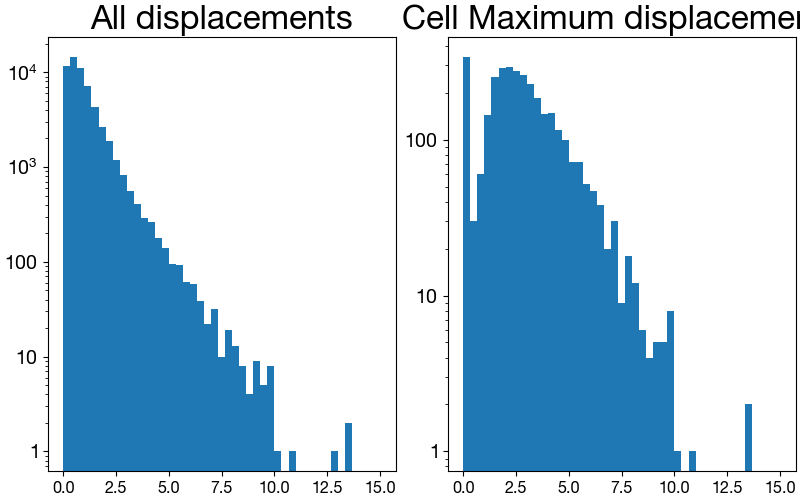

In [28]:
fig, ax = plt.subplots(1,2,sharex=True)
ax[0].hist(disp.loc[pd.IndexSlice[:,:,2:]].dropna().values, bins=45, range=[0,15], )
ax[0].set_title("All displacements")
ax[1].hist(cell_max_disps, bins=45, range=[0,15],)
ax[1].set_title("Cell Maximum displacements")
for a in ax:
    a.semilogy();

In [29]:
# x = disp.loc[(0, 150)]
# df = disp.loc[(0,15)]

In [30]:
def check_consecutive(x, N=15):
    m = x.isna()
    s = m.cumsum()
    final_mask = s.map(s[~m].value_counts()).ge(N) & ~m
    return final_mask

In [31]:
# Specific entries that are a part of a 20+ consecutive observation run
nconsec = 15
consecutive_cells = disp.groupby(['S','CellID'], group_keys=False).apply(check_consecutive, N=nconsec)

In [32]:
disp_consecutive = disp.loc[consecutive_cells].unstack('T')

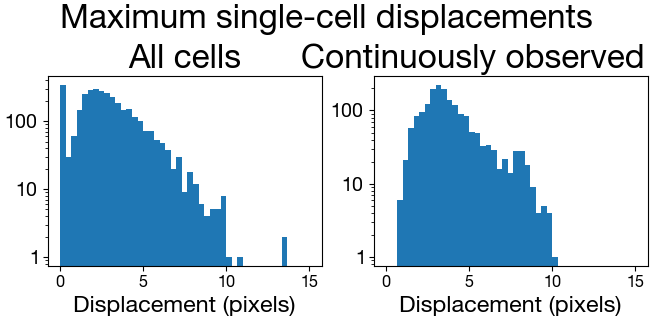

In [33]:
fig, ax = plt.subplots(1,2,sharex=True, figsize=(6.52,3.2))
ax[0].hist(cell_max_disps.values, bins=45, range=[0,15], )
ax[0].set_title("All cells")
ax[1].hist(disp_consecutive.max(1).values, bins=45, range=[0,15],)
ax[1].set_title("Continuously observed cells")
ax[0].set_xlabel("$N_i{cells}$")
fig.suptitle("Maximum single-cell displacements")
for a in ax:
    a.semilogy()
    a.set_xlabel("Displacement (pixels)")
if savefigs:
    plt.savefig(fig_path+"max_disps.png")

In [34]:
big_jump = (disp_consecutive.loc[:,2:].groupby(['S','CellID']).max()>8).stack('T')

In [35]:
jump_idx = big_jump.loc[big_jump].reset_index('T').index.unique()

In [36]:
# check = check_labels_from_multiindex(ds.labels, jump_idx)

# v = napari.Viewer()
# il= v.add_image(srs_bsub)
# fl = v.add_image(aligned_fluo)
# # ll = v.add_labels(ds.labels)
# cl = v.add_labels(check)

In [37]:
#big_jump_cell_times = big_jump.loc[big_jump].reset_index('T')['T']

In [38]:
no_jumps = big_jump.groupby(cell).sum()==0
# no_jump_idx = no_jumps.loc[no_jumps].index

In [39]:
consecutive_coms = coms.loc[consecutive_cells]
central_cells = ((consecutive_coms['X'].between(5,507))&(consecutive_coms['Y'].between(5,507))).groupby(cell).all()

In [40]:
srs_clean = srs_avgs.loc[consecutive_cells].unstack('T').loc[no_jumps&central_cells]
# max_clean = max_avgs.loc[consecutive_cells].unstack('T').loc[no_jumps&central_cells]
# raw_clean = raw_avgs.loc[consecutive_cells].unstack('T').loc[no_jumps&central_cells]

In [41]:
consecutive_cells.unstack('T').sum().max()

1762

In [42]:
central_cells.sum()

1670

In [43]:
srs_clean.shape[0]

1646

In [45]:
# srs_clean.to_csv("/Users/johnrussell/Data/2023-05-16/2023-05-16-srs.csv")
# areas_clean.to_csv("/Users/johnrussell/Data/2023-05-16/2023-05-16-area.csv")

In [46]:
areas_clean = areas.loc[consecutive_cells].unstack('T').loc[no_jumps&central_cells]

In [47]:
# first_times_clean = areas_clean.stack('T').reset_index('T').groupby(cell).first().set_index('T', append=True).index
first = srs_clean.stack('T').reset_index('T').groupby(cell).first().set_index('T', append=True).iloc[:,0]

In [48]:
all_first = srs_avgs.reset_index('T').dropna().groupby(cell).first().set_index('T', append=True).iloc[:,0]

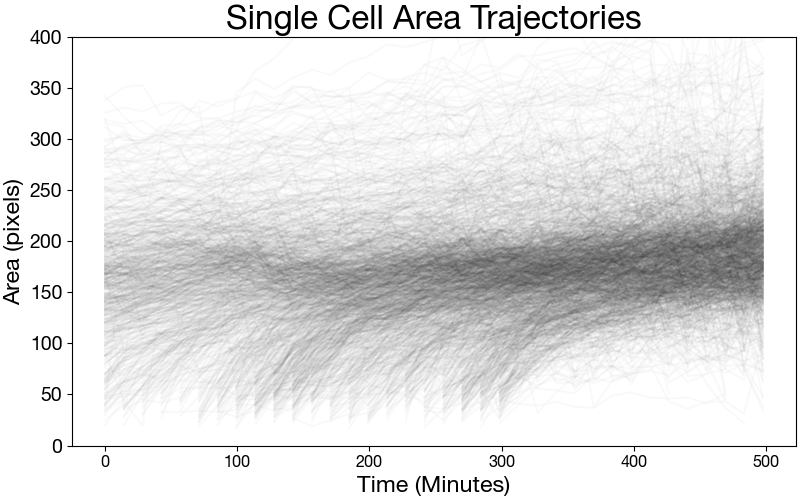

In [49]:
plt.figure()
plt.plot(t_data, areas_clean.values.T, 'k', alpha=0.025);
# plt.errorbar(t_data, areas_clean.median().values, yerr=(areas_clean.quantile([0.25,0.75])-areas_clean.median()).abs().values, fmt='mo', capsize=3)
plt.ylim([0,400])
plt.title("Single Cell Area Trajectories")
plt.ylabel("Area (pixels)")
plt.xlabel("Time (Minutes)")
if savefigs:
    plt.savefig(fig_path+"cell_areas.png");

In [50]:
growth_cells = areas_clean.loc[(areas_clean.stack('T').loc[first.index]<100).droplevel("T")]

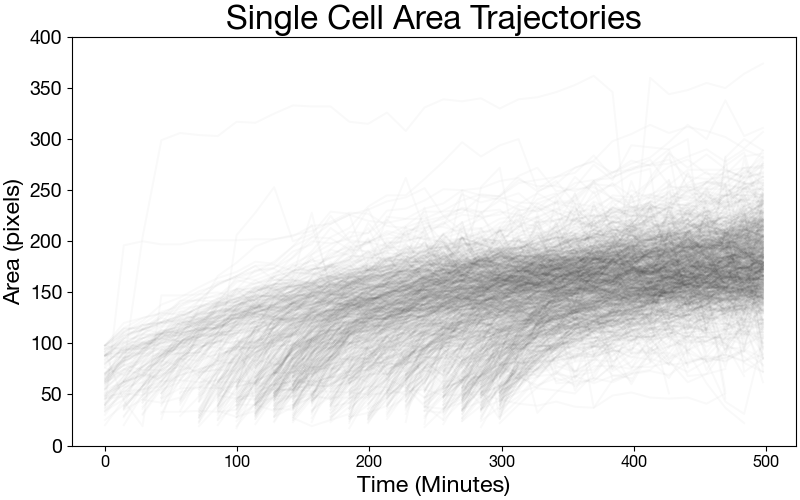

In [51]:
plt.figure()
plt.plot(t_data, growth_cells.values.T, 'k', alpha=0.025);
# plt.errorbar(t_data, areas_clean.median().values, yerr=(areas_clean.quantile([0.25,0.75])-areas_clean.median()).abs().values, fmt='mo', capsize=3)
plt.ylim([0,400])
plt.title("Single Cell Area Trajectories")
plt.ylabel("Area (pixels)")
plt.xlabel("Time (Minutes)")
if savefigs:
    plt.savefig(fig_path+"cell_areas.png");

**Note** `fit_all_exponentials` should maybe take an arg about an offset and whether to use absolute or relative t values

In [52]:
# srs_jumps = (srs_clean.diff(axis=1).abs()>15).any(1)
# check_idx = srs_jumps.loc[srs_jumps].index

In [53]:
# time_count = srs_avgs.groupby(['S','CellID']).count()

# present = (~srs_avgs.unstack(['S','CellID']).isna()).astype(int)
# appears_once = (present.diff()==1).astype(int).sum()<2
# disappears_once = (present.diff()==-1).astype(int).sum()<2

# keep = srs_avgs.unstack('T').loc[(appears_once & disappears_once & (time_count>15)), :35]

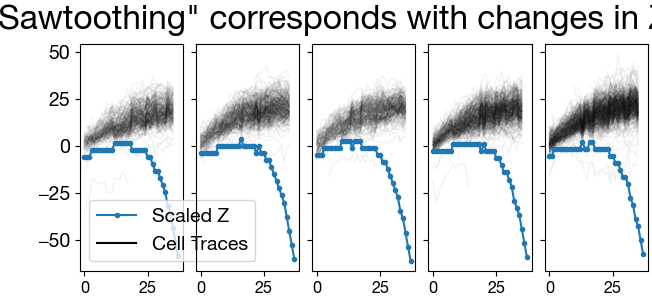

In [54]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(6.52,3))
for s in range(5):
    traces = ax[s].plot(srs_clean.loc[s].values.T, 'k', linewidth=1, alpha=0.05)
    ax[s].plot(5*(zpos.loc[s]-zpos.loc[s].mean())-10, '.-', label='Scaled Z')
    
ylim = ax[0].get_ylim()
ax[0].plot(20,100,'k', label='Cell Traces')
ax[0].set_ylim(ylim)
ax[0].legend();
plt.suptitle("\"Sawtoothing\" corresponds with changes in Z")
if savefigs:
    plt.savefig(fig_path+"sawtooth_abs_z.png")

In [55]:
# fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(10,3))
# for s in range(5):
#     traces = ax[s].plot(max_clean.loc[s].values.T, 'k', linewidth=1, alpha=0.05)
#     ax[s].plot(5*(zpos.loc[s]-zpos.loc[s].mean())-10, '.-', label='Scaled Z postion')
    
# ylim = ax[0].get_ylim()
# ax[0].plot(20,100,'k', label='Cell Traces')
# ax[0].set_ylim(ylim)
# ax[0].legend()
# plt.suptitle("Sawtooth seems to correspond to changes in Z (max projections)")

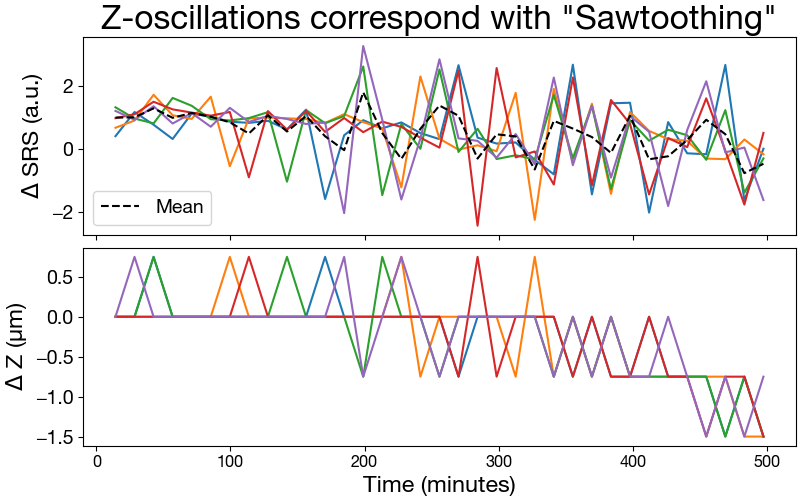

In [56]:
dz = zpos.groupby('S').diff()['Z'].loc[(slice(None), slice(srs_clean.columns.max()))]
dsrs = srs_clean.diff(axis=1)#/dt_min

fig, ax = plt.subplots(2,1, sharex=True, )
for s in range(5):
    ax[0].plot(t_data, dsrs.loc[s].mean().values, color=colors[s])
    ax[1].plot(t_data, dz.loc[s].values, color=colors[s])    
ax[0].plot(t_data, dsrs.mean().values, 'k--', label="Mean")
ax[0].legend(loc='lower left')
# ax[0].plot(xplt, dy, 'k')
ax[1].set_xlabel("Time (minutes)")
ax[0].set_ylabel("$\Delta$ SRS (a.u.)")
ax[1].set_ylabel("$\Delta$ Z (µm)")
ax[0].set_title("Z-oscillations correspond with \"Sawtoothing\"")
if savefigs: plt.savefig(fig_path+"sawtooth_deltas.png")

### Multiplicative correction

In [57]:
from scipy.optimize import minimize

In [58]:
def d2loss_with_reg(k, x, alpha=1):
    d = np.diff((1+k)*x, n=2, axis=-1)
    d = d*d
    w = np.convolve((1+k), [1,2,1], mode='valid')
    w = w*w
    return np.nanmean(d/w) + alpha*np.mean(k*k)

In [59]:
def d2loss_with_reg_bcs(k, x, alpha=1.):
    s = 1+k
    y = s*x
    d = np.zeros_like(y)
    d[:,1:-1] = -2*y[:,1:-1] + y[:,2:] + y[:,:-2]
    d[:,0] = y[:,0] -2*y[:,1] + y[:,2]
    d[:,-1] = y[:,-1] -2*y[:,-2] + y[:,-2]
    d = d*d
    w = np.zeros_like(s)
    w[1:-1] = 2*s[1:-1] + s[2:] +s[:-2]
    w[0] = s[0]+2*s[1]+s[2]
    w[-1] = s[-1]+2*s[-2]+s[-3]
    w = w*w
    return np.nanmean(d/w) + alpha*np.mean(k*k)

In [60]:
na = 9
nt = srs_clean.shape[1]
ns = 5
alphas = np.logspace(-2,2, num=na)
avgs = np.zeros((ns, nt, na))
kopts = np.zeros((ns, nt, na))
tloss = np.zeros((ns, na))

for s in tqdm(range(ns)):
    y = srs_clean.loc[s].values
    val_mask = np.zeros(y.shape[0],dtype='bool')
    val_mask[np.random.choice(np.arange(y.shape[0]),size=50, replace=False)]=1
    val = y[val_mask]
    train = y[~val_mask]

    for i,a in enumerate(tqdm(alphas, leave=False)):
        res = minimize(d2loss_with_reg_bcs, np.zeros(nt), (train, a))
        kopts[s,:,i] = res.x
        tloss[s,i] = res.fun
        avgs[s,:,i] = np.nanmean((1+res.x)*train, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

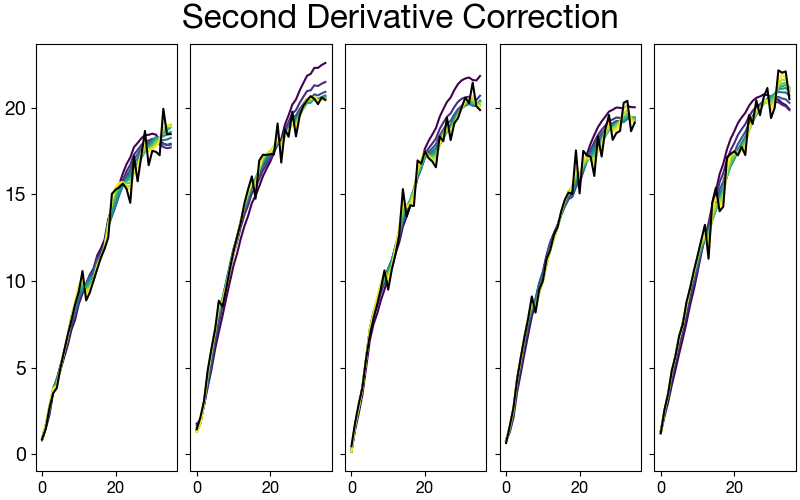

In [61]:
viridis_colors = plt.cm.viridis(np.linspace(0,1,alphas.shape[0]))
fig, axs = plt.subplots(1,5, sharex=True, sharey=True)
for s, ax in zip(range(ns), axs):
    for x, c, a in zip(avgs[s].T, viridis_colors, alphas):
        ax.plot(x, color=c, label=f"{a:0.2e}")
    ax.plot(srs_clean.loc[s].mean().values, 'k', label='Original')
fig.suptitle('Second Derivative Correction')
# axs[-1].legend(title="Regularization parameter", loc='upper right',bbox_to_anchor=(1.35, 1.05))
if savefigs: plt.savefig(fig_path+"wt_d2_correction.png")

In [62]:
kopt= pd.DataFrame(kopts[...,4], index=pd.Index(range(kopts.shape[0]), name='S'), columns=pd.Index(range(kopts.shape[1]), name='T'))

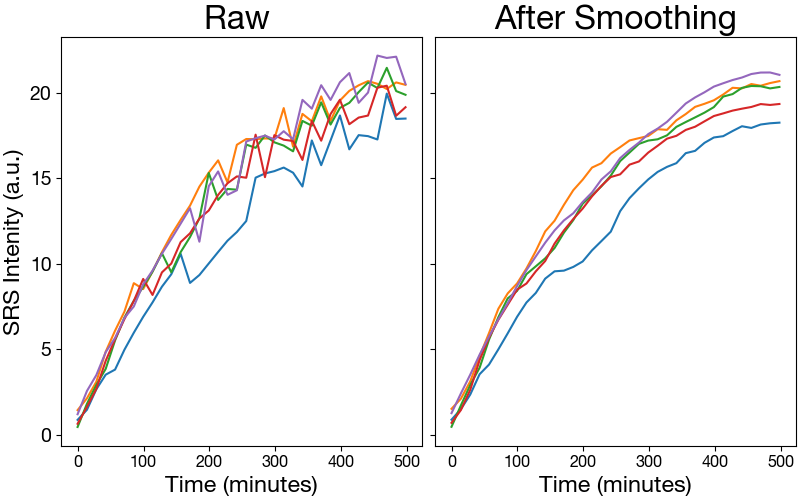

In [63]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
for i in range(5):
    ax[0].plot(t_data, srs_clean.loc[i].mean().values, color=colors[i])
    ax[1].plot(t_data, (1+kopt.loc[i].values)*srs_clean.loc[i].mean().values, color=colors[i])
ax[0].set_title("Raw ")
ax[1].set_title("After Smoothing")
ax[0].set_xlabel("Time (minutes)")
ax[1].set_xlabel("Time (minutes)")
ax[0].set_ylabel("SRS Intenity (a.u.)")
if savefigs: plt.savefig(fig_path+"sawtooth_corr.png")

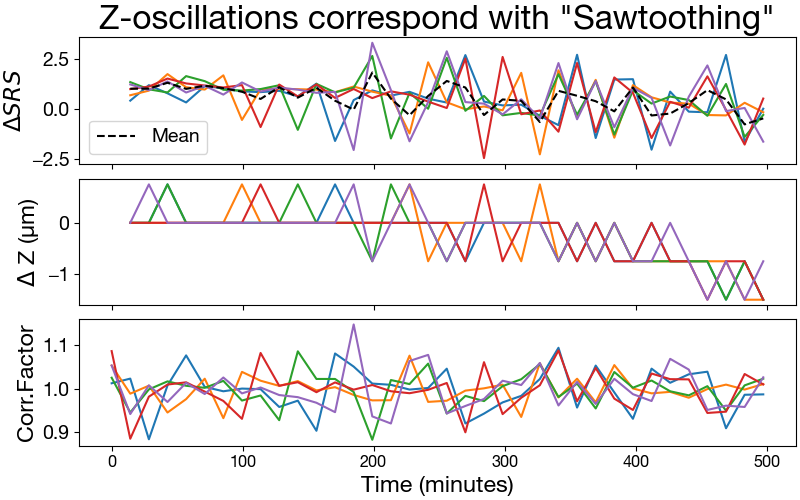

In [64]:
fig, ax = plt.subplots(3,1, sharex=True, )
for s in range(5):
    ax[0].plot(t_data, dsrs.loc[s].mean().values, color=colors[s])
    ax[1].plot(t_data, dz.loc[s].values, color=colors[s])    
    ax[2].plot(t_data, 1+kopt.loc[s], color=colors[s])
ax[0].plot(t_data, dsrs.mean().values, 'k--', label="Mean")
ax[0].legend(loc='lower left')
# ax[0].plot(xplt, dy, 'k')
ax[-1].set_xlabel("Time (minutes)")
ax[0].set_ylabel("$\Delta SRS$")
ax[1].set_ylabel("$\Delta$ Z (µm)")
ax[2].set_ylabel("Corr.Factor")
ax[0].set_title("Z-oscillations correspond with \"Sawtoothing\"")
if savefigs:
    plt.savefig(fig_path+"wt_sawtooth_deltas_weights.png")

In [65]:
srs_recon = (1+kopt)*srs_clean

In [66]:
all_recon = (1+kopt)*(srs_avgs.unstack('T'))

### Inspect rescaled data

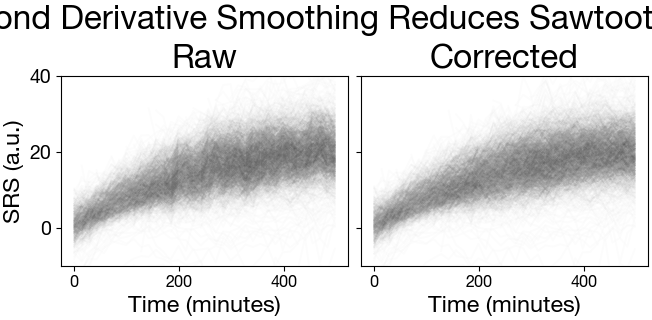

In [67]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(6.52,3.2))
ax[0].plot(t_data, srs_clean.values.T, 'k', alpha=0.01);
ax[0].set_title('Raw')

ax[1].plot(t_data, srs_recon.values.T, 'k', alpha=0.01);
ax[1].set_title('Corrected')
ax[0].set_ylabel("SRS (a.u.)")
fig.suptitle("Second Derivative Smoothing Reduces Sawtoothing")
for a in ax:
    a.set_xlabel("Time (minutes)");
    a.set_ylim([-10,40])
if savefigs:
    plt.savefig(fig_path+"saw_corr_before_after.png")

In [ ]:
plt.figure()
plt

## Curve fitting

In [68]:
def exp_approach(x, a, k):
    return a*(1-np.exp(-k*x))#+b

def exp_approach2(x, a, k,t):
    return a*(1-np.exp(-k*(x-t)))#+b

def exp_approach3(x, a, k, b):
    return a*(1-np.exp(-k*x))+b

def exp_decay(x, a, b, k):
    return a*np.exp(-k*x)#+b

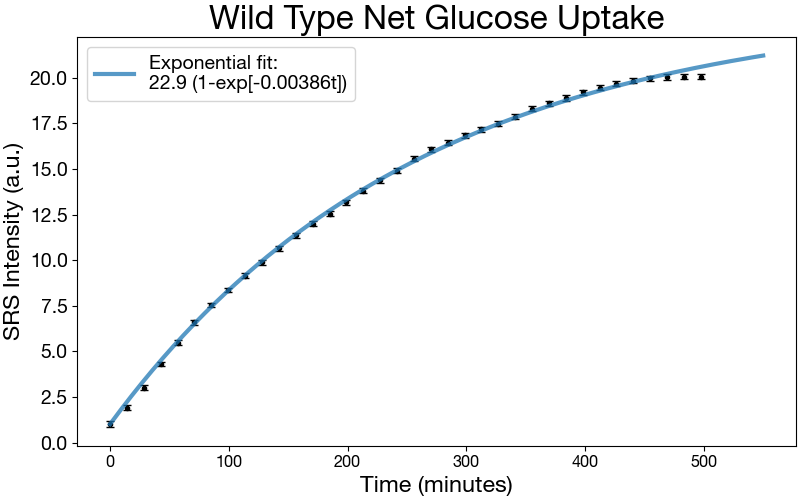

In [69]:
df = srs_recon
# xdata = dt_min*df.columns.values + 30
y = df.mean().values
y_offset = y[0]
y = y-y_offset
sigma = df.sem().values

fit = curve_fit(exp_approach, t_data, y, sigma=sigma, p0=[20, 0.1], bounds=(0,np.inf))

a,k = fit[0]
eqn = f"Exponential fit: \n{a:0.1f} (1-exp[-{k:0.3g}t])"
xplt = np.linspace(0, 550, 250)
plt.figure()
plt.plot(xplt, exp_approach(xplt, *fit[0])+y_offset, zorder=0, linewidth=3, alpha=0.75, label=eqn)
# plt.plot(t_data, y+y_offset, 'k.', zorder=-1)
plt.errorbar(t_data, y+y_offset,yerr=sigma, fmt='k.', capsize=3, zorder=-1)
plt.title(f"Wild Type Net Glucose Uptake")
plt.legend()
plt.xlabel("Time (minutes)")
plt.ylabel("SRS Intensity (a.u.)")
if savefigs:
    plt.savefig(fig_path+"bulk_fit.png")

In [70]:
np.sqrt(fit[1][1,1])

6.189810729943325e-05

In [71]:
# srs_total = srs_recon*areas_clean

# fig,ax = plt.subplots(1,2, sharex=True,figsize=(6.52, 3.2))
# ax[0].plot(t_data, srs_recon.values.T, 'k', linewidth=1, alpha=0.02)
# ax[0].set_xlabel("Time (minutes)")
# ax[0].set_ylabel("SRS Intensity (a.u.)")
# ax[0].set_title("Averages")
# ax[0].set_ylim([-10,40])
# ax[1].plot(t_data, srs_total.values.T, 'k', linewidth=1, alpha=0.02)
# ax[1].set_xlabel("Time (minutes)")
# # ax[1].set_ylabel("SRS Intensity (a.u.)")
# ax[1].set_title("Totals")
# ax[1].set_ylim([-2000, 8000])
# fig.suptitle("Single Cell Traces");
# if savefigs:
#     plt.savefig(fig_path+"sc_area_total.png")

## Single Cell Analysis

In [72]:
def fit_exp(x, y, p0):
    try:
        p, cov = curve_fit(exp_approach, x, y, p0=p0, bounds=(0,np.inf), absolute_sigma=True)
        out = np.array([*p, *np.diag(cov)])
    except RuntimeError:
        out = np.full(2*len(p0), np.nan)
    return out

In [73]:
# slower to use dask delayed by ~50%
df = srs_recon

all_srs_params = pd.DataFrame(index=df.index, columns=['a','k', 'sig_a', 'sig_k','x0','y0'], dtype='f4')

for i, (idx, s) in enumerate(tqdm(df.iterrows(), total=len(df))):
    y = s.values
    mask = ~np.isnan(y)
    y = y[mask]
    y_offset = y[0]
    y = y-y_offset
    x = t_data[mask]
    x_offset = x[0]
    x = x - x_offset
    out = fit_exp(x,y,fit[0])
    all_srs_params.loc[idx] = [*out, x_offset, y_offset]

  0%|          | 0/1646 [00:00<?, ?it/s]

In [74]:
unconverged = all_srs_params.loc[all_srs_params.isna().any(axis=1)].index
srs_params = all_srs_params.dropna()

In [75]:
# outfile = working_dir+f"{ename}_srs_tables.h5"
# srs_clean.to_hdf(outfile, key='raw')
# srs_recon.to_hdf(outfile, key='recon')
# areas_clean.to_hdf(outfile, key='area')
# srs_params.to_hdf(outfile, key='params')

In [76]:
pcts = np.linspace(0,1, 101)
qs = srs_params.quantile(pcts)

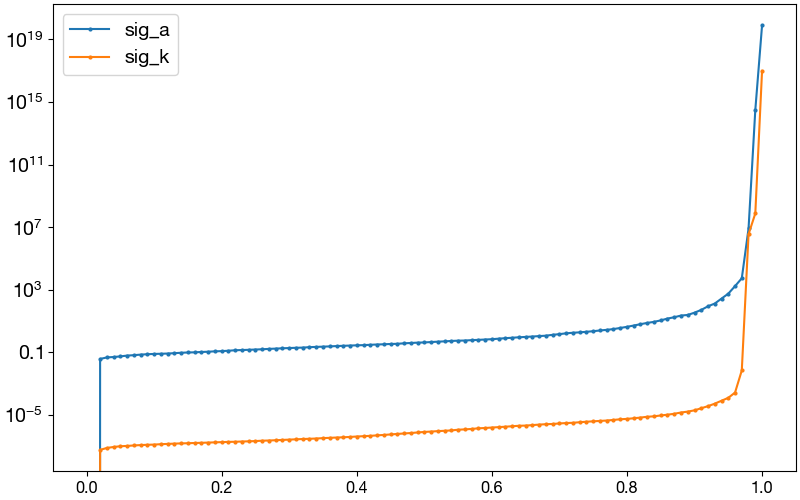

In [77]:
plt.figure()
tc = 3
plt.plot(pcts, qs.sig_a.values, '-o', markersize=2, label='sig_a')
plt.plot(pcts, qs.sig_k.values,'-o', markersize=2,label='sig_k')
plt.legend()
plt.semilogy();

In [78]:
vqs = (srs_params['a']*srs_params['k']).quantile(pcts)

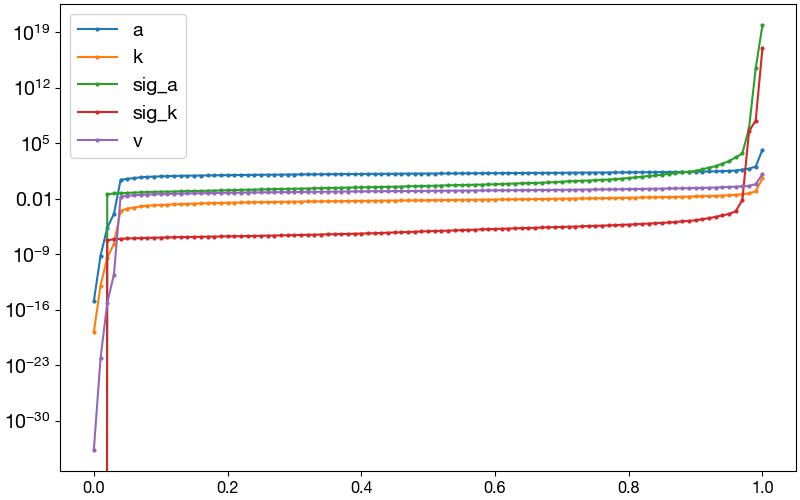

In [79]:
plt.figure()

plt.plot(pcts, qs.a.values, '-o', markersize=2, label='a')
plt.plot(pcts, qs.k.values,'-o', markersize=2,label='k')
plt.plot(pcts, qs.sig_a.values, '-o', markersize=2, label='sig_a')
plt.plot(pcts, qs.sig_k.values,'-o', markersize=2,label='sig_k')
plt.plot(pcts, vqs.values, '-o', markersize=2, label='v')
plt.legend()
plt.semilogy();

In [80]:
low_q = (srs_params<qs.iloc[2]).any(axis=1)
low_q = low_q.loc[low_q]
print(len(low_q))

81


In [81]:
high_q = (srs_params>qs.iloc[-2]).any(axis=1)
high_q = high_q.loc[high_q]
print(len(high_q))

61


In [82]:
mid_q = ((srs_params>qs.iloc[2]).all(axis=1))&((srs_params<qs.iloc[-2]).all(axis=1))
mid_q = mid_q.loc[mid_q]

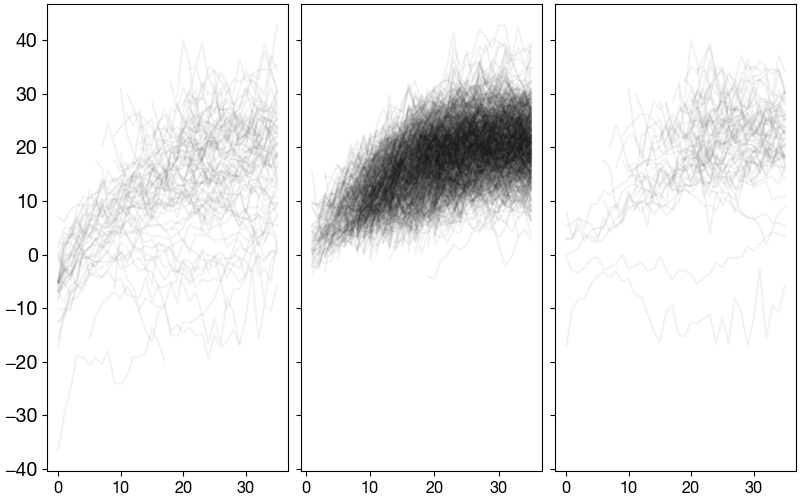

In [83]:
fig, ax = plt.subplots(1,3, sharey=True)
ax[0].plot(srs_recon.loc[low_q.index].values.T, 'k', alpha=0.05)
ax[1].plot(srs_recon.loc[mid_q.index].values.T, 'k', alpha=0.05)
ax[2].plot(srs_recon.loc[high_q.index].values.T, 'k', alpha=0.05);

In [84]:
k_sig_k =np.sqrt(srs_params['sig_k'])/ srs_params['k']

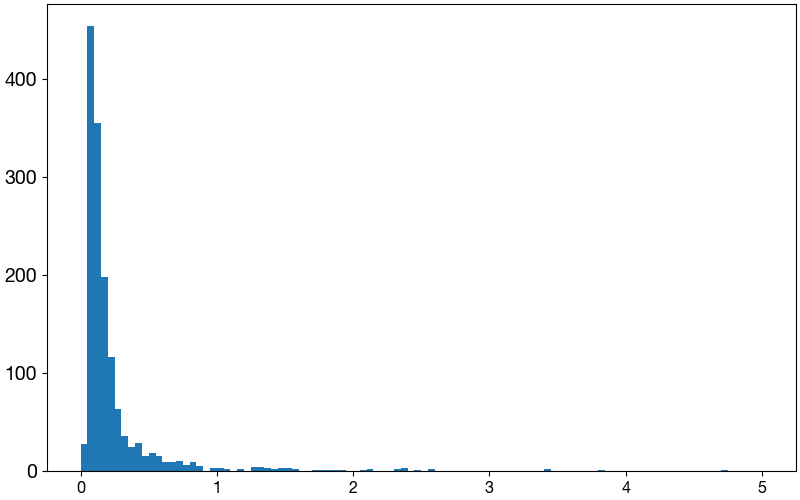

In [85]:
plt.figure()
_ = plt.hist(k_sig_k.loc[np.isfinite(k_sig_k)].values, bins=100, range=(0,5))

Text(0.5, 1.0, '$\\sigma_k \\in [1\\%, 99\\%]$')

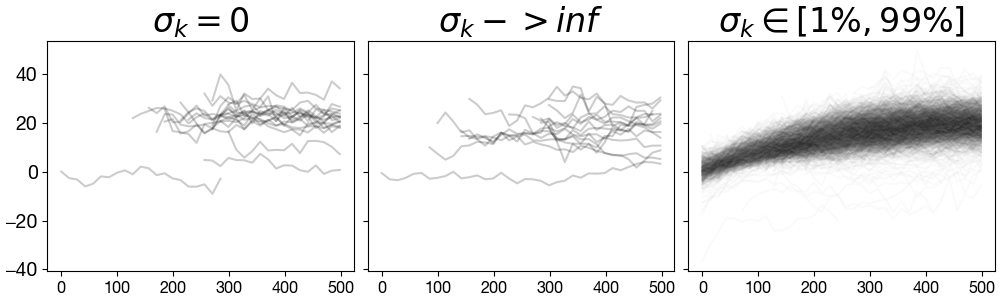

In [86]:
df = srs_recon.loc[srs_params.index]
fig, ax = plt.subplots(1,3,sharex=True, sharey=True, figsize=(10,3))
ax[0].plot(t_data, df.loc[srs_params.index].loc[srs_params['sig_k']==0].values.T, 'k', alpha=0.2);
ax[0].set_title('$\sigma_k=0$')

ax[1].plot(t_data, df.loc[srs_params['sig_k']>qs.loc[0.99, 'sig_k']].values.T, 'k', alpha=0.2);
ax[1].set_title('$\sigma_k -> inf$')

ax[2].plot(t_data, df.loc[srs_params['sig_k'].between(*qs.loc[[0.02, 0.99],'sig_k'])].values.T, 'k', alpha=0.02);
ax[2].set_title('$\sigma_k \in [1\%, 99\%]$')

Text(0.5, 1.0, 'Traces with uncoverged exponential paramters')

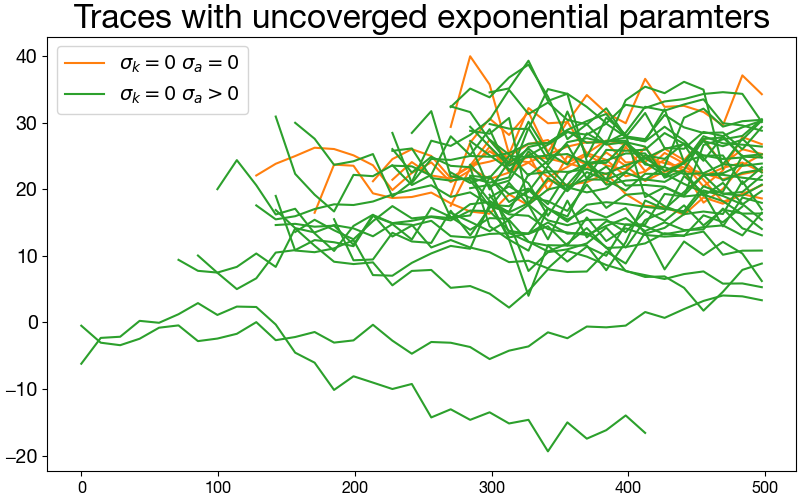

In [87]:
df = srs_recon.loc[srs_params.index]
fig, ax = plt.subplots()
# l1 = plt.plot(t_data, df.loc[(srs_params['sig_k']==0)&(srs_params['sig_a']==0)].values.T, color=colors[0]);
l2=  plt.plot(t_data, df.loc[(srs_params['sig_k']==0)&(srs_params['sig_a']>0)].values.T, color=colors[1]);
l3=  plt.plot(t_data, df.loc[(srs_params['sig_k']>1)].values.T, color=colors[2]);
plt.legend([l[0] for l in ( l2, l3)],['$\sigma_k=0$ $\sigma_a=0$', '$\sigma_k=0$ $\sigma_a>0$', '$\sigma_k>1$']);
plt.title("Traces with uncoverged exponential paramters")

In [88]:
sig_k_sel = srs_params['sig_k'].between(*qs.loc[[0.02, 0.98],'sig_k'])#.between(1e-16, 1e4)
sig_a_sel = srs_params['sig_a'].between(*qs.loc[[0.02, 0.98],'sig_a'])#.between(1e-16,1e5)#.between(1e-16,10)

In [89]:
hrange =(0, srs_params['k'].quantile([0.98]).item())

In [90]:
w = 1./srs_params.loc[sig_k_sel,'sig_k']
# w = w*w
w /= w.sum()

k 0.0055 0.010253697
a 14.5 18.050482


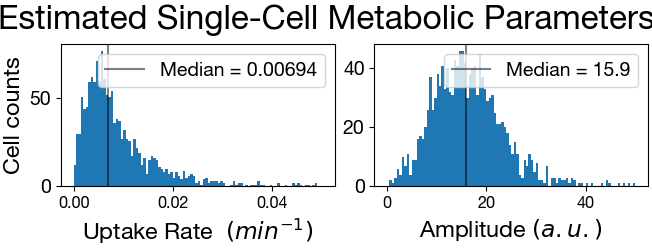

In [91]:
fig, ax = plt.subplots(1,2, figsize=(6.52, 2.5))
df = srs_params.loc[sig_k_sel&sig_a_sel]
hranges = ([0,0.05], [0,50])
for i,x in enumerate('ka'):
    # w = 1./df[f'sig_{x}']
    # w /= w.sum()
    
    counts, bins, patches = ax[i].hist(df[x].values, bins=100, range=hranges[i])
    print(x, bins[np.argmax(counts)], df[x].mean())
    ax[i].axvline(df[x].median(), color='k', alpha=0.5, label=f'Median = {df[x].median():0.3g}')
    ax[i].legend()
ax[0].set_xlabel(r"Uptake Rate  $\left(min^{-1}\right)$")
ax[1].set_xlabel(r"Amplitude $\left( a.u. \right)$")

ax[0].set_ylabel("Cell counts")

fig.suptitle("Estimated Single-Cell Metabolic Parameters")
if savefigs:
    plt.savefig(fig_path+"sc_params.png")

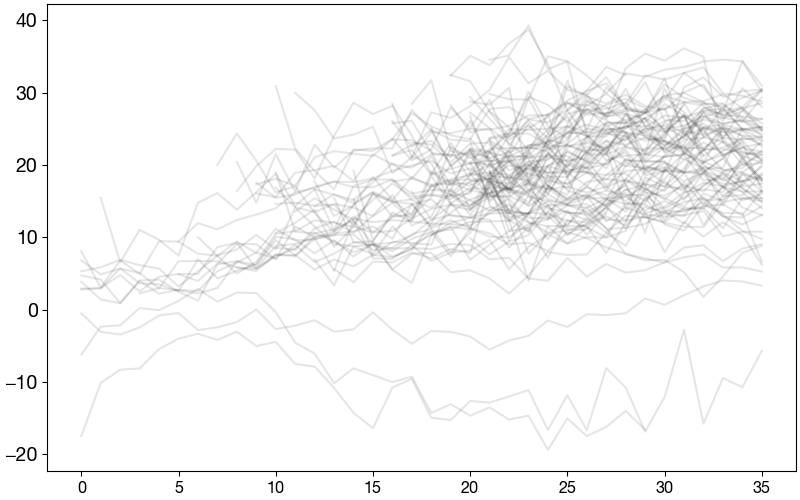

In [92]:
plt.figure()
plt.plot(srs_recon.loc[srs_recon.index.intersection(srs_params.loc[(np.sqrt(srs_params.sig_k)/srs_params.k)>=1].index)].values.T, 'k', alpha=0.1);

k 0.0055 0.022779152
a 14.5 35.50889


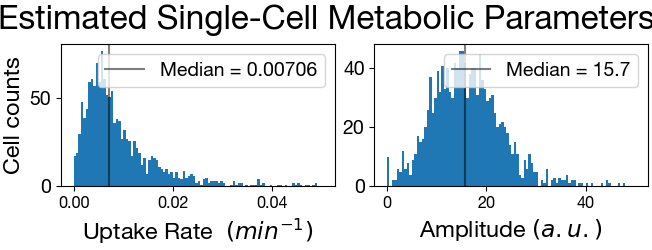

In [93]:
fig, ax = plt.subplots(1,2, figsize=(6.52, 2.5))
df = srs_params.loc[(np.sqrt(srs_params.sig_k)/srs_params.k)<=1]
hranges = ([0,0.05], [0,50])
for i,x in enumerate('ka'):
    # w = 1./df[f'sig_{x}']
    # w /= w.sum()
    
    counts, bins, patches = ax[i].hist(df[x].values, bins=100, range=hranges[i])
    print(x, bins[np.argmax(counts)], df[x].mean())
    ax[i].axvline(df[x].median(), color='k', alpha=0.5, label=f'Median = {df[x].median():0.3g}')
    ax[i].legend()
ax[0].set_xlabel(r"Uptake Rate  $\left(min^{-1}\right)$")
ax[1].set_xlabel(r"Amplitude $\left( a.u. \right)$")

ax[0].set_ylabel("Cell counts")

fig.suptitle("Estimated Single-Cell Metabolic Parameters")
if savefigs:
    plt.savefig(fig_path+"sc_params.png")

In [94]:
df = df.drop((0,96))

In [95]:
bigk = df.loc[df.k>0.025]
smallk = df.loc[df.k<0.005]

In [96]:
xy_big= bigk.groupby('x0')['y0']
xy_small= smallk.groupby('x0')['y0']

In [97]:
xy_big.get_group(0)

S  CellID
0  107       -1.738240
1  91        -6.947553
2  34         1.443276
4  118      -15.724234
Name: y0, dtype: float32

/var/folders/kf/00b2m7cs64ddpwn284qvdzv80000gn/T/ipykernel_62867/1605651066.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<ErrorbarContainer object of 3 artists>

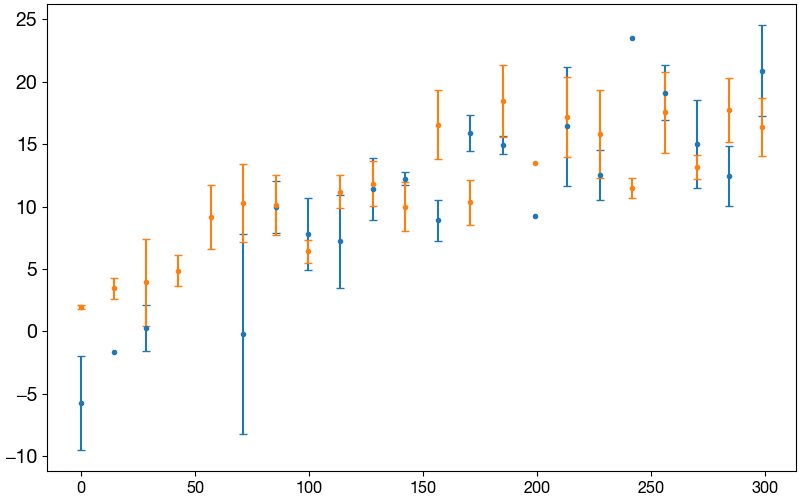

In [98]:
plt.figure()
plt.errorbar(xy_big.mean().index, xy_big.mean(),yerr=xy_big.sem(), fmt='.', capsize=3)
plt.errorbar(xy_small.mean().index, xy_small.mean(),yerr=xy_small.sem(), fmt='.', capsize=3)

(array([654.,  44.,  65., 101., 122.,  77.,  73.,  66.,  62., 139.]),
 array([  0.      ,  29.84869 ,  59.69738 ,  89.546074, 119.39476 ,
        149.24345 , 179.09215 , 208.94084 , 238.78952 , 268.6382  ,
        298.4869  ], dtype=float32),
 <BarContainer object of 10 artists>)

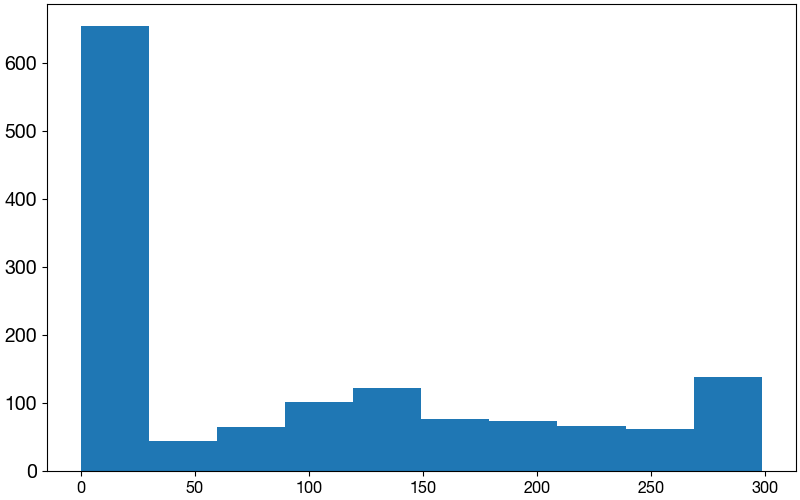

In [99]:
plt.figure()
plt.hist(df['x0'])

Text(0.5, 1.0, 'Net Glucose Uptake Rates $\\left( A\\cdot k\\right)$')

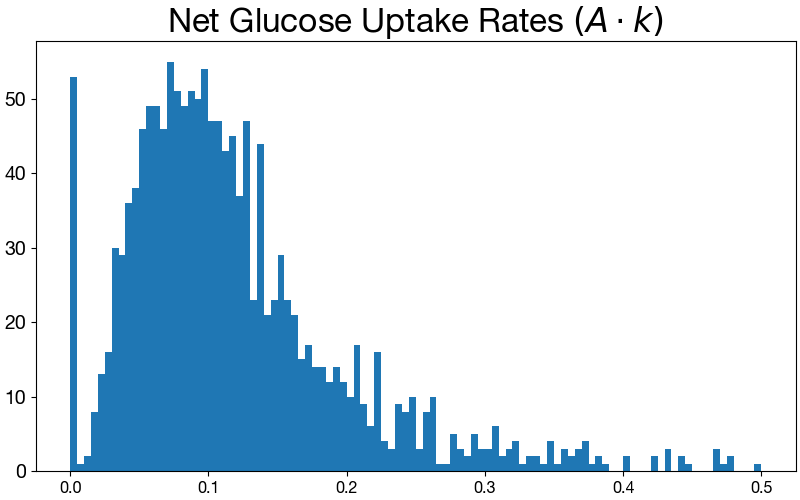

In [100]:
plt.figure()
counts, bin, patches = plt.hist((srs_params['a']*srs_params['k']).values, bins=100, range=(0,0.5))
plt.title("Net Glucose Uptake Rates $\\left( A\cdot k\\right)$")

In [101]:
params_by_age = df.join(first.reset_index('T')['T']).groupby('T').mean()
params_by_age_sem = df.join(first.reset_index('T')['T']).groupby('T').sem()

In [102]:
# fig, ax = plt.subplots(1,2)
# ax[0].errorbar(t_data[:22], params_by_age['k'], params_by_age_sem['k'], fmt='o', capsize=3)
# ax[0].set_ylabel("k")
# ax[0].set_xlabel("Time of birth")
# plt.semilogy();

In [103]:
bkgd_avgs = srs_bsub.where(ds.labels==0).mean(list('YX'))

In [104]:
bkgd_stds = srs_bsub.where(ds.labels==0).std(list('YX'))

In [105]:
print(bkgd_avgs.min().item(), bkgd_avgs.max().item())

-0.1705356389284134 3.0352039337158203


In [106]:
print(bkgd_stds.min().item(), bkgd_stds.max().item())

9.196843147277832 13.007076263427734


In [107]:
bad = srs_recon.loc[(srs_recon<-1*bkgd_stds.mean().item()).any(axis=1)]

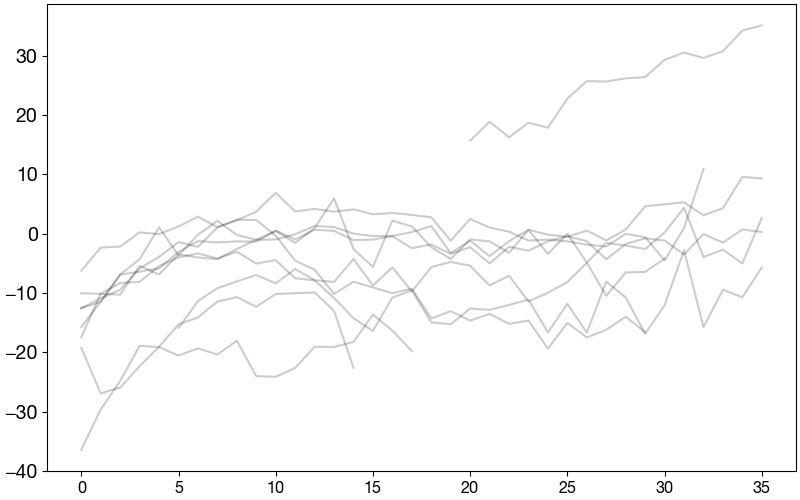

In [108]:
plt.figure()
plt.plot(bad.values.T, 'k', alpha=0.2);

In [109]:
srs_params.join(pd.Series(index=bad.index, name='x'), how='inner')

/var/folders/kf/00b2m7cs64ddpwn284qvdzv80000gn/T/ipykernel_62867/2437543482.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  srs_params.join(pd.Series(index=bad.index, name='x'), how='inner')


a             k         sig_a         sig_k         x0  \
S CellID                                                                   
0 96      17.088688  4.692188e-02  8.433635e-02  2.616599e-05   0.000000   
  119     11.225087  2.392462e-02  4.086529e-02  7.856925e-06   0.000000   
2 116      8.673978  5.390311e-02  4.860221e-02  1.380433e-04  71.068314   
3 99      14.302949  2.111975e-02  4.995380e-02  3.598853e-06   0.000000   
  19      15.717544  4.408121e-03  7.283200e-01  2.610115e-07   0.000000   
4 118     14.820521  3.844374e-02  3.493438e-02  1.691942e-05   0.000000   
  201      7.487871  3.037777e-01  2.945858e-02  5.115612e-01   0.000000   
  211      0.000007  1.346277e-09  2.366770e+13  1.000929e+06   0.000000   

                 y0   x  
S CellID                 
0 96     -36.438614 NaN  
  119    -12.541917 NaN  
2 116    -15.876434 NaN  
3 99     -12.571007 NaN  
  19     -10.033688 NaN  
4 118    -15.724234 NaN  
  201    -17.454746 NaN  
  211     -6.210822 NaN

In [110]:
srs_recon.loc[srs_recon[0]<-10]

T                0          1          2          3          4          5   \
S CellID                                                                     
0 96     -36.438613 -29.609415 -24.816018 -18.888740 -19.120935 -20.537508   
  119    -12.541917 -11.482448  -6.900096  -6.378673  -5.842731  -3.068278   
3 99     -12.571007 -10.876785  -9.453342  -5.843661  -3.896628  -1.393364   
  123    -19.250579 -26.902797 -25.933651 -22.320219 -19.039311 -15.286830   
  19     -10.033688 -10.127246 -10.274298  -5.416159  -6.861161  -3.472329   
4 118    -15.724234 -11.444939  -6.863105  -4.305484   1.105609  -3.648388   
  201    -17.454747 -10.113222  -8.292069  -8.115552  -5.451362  -3.986747   

T                6          7          8          9   ...         26  \
S CellID                                              ...              
0 96     -19.316802 -20.362714 -18.035193 -24.006819  ...        NaN   
  119     -1.236008  -1.453386  -1.282094  -1.330882  ...  -1.259279   
3 99      -2.210745   1.060732   2.264104   3.738437  ...  -1.838484   
  123    -14.104309 -11.440668 -10.670991 -12.313016  ...  25.741967   
  19      -3.987462  -4.283028  -2.555572  -1.000413  ...   0.543478   
4 118     -0.160288   2.178358  -0.197794  -1.014353  ...  -4.860118   
  201     -3.312662  -4.178724  -3.026533  -5.018146  ... -16.664541   

T                27         28         29         30         31         32  \
S CellID                                                                     
0 96            NaN        NaN        NaN        NaN        NaN        NaN   
  119     -4.297531  -1.736665  -0.767060  -1.135529  -3.492227  -0.042457   
3 99      -2.139807  -0.017519  -0.578168  -4.489902   0.987115  10.908014   
  123     25.663173  26.205521  26.415106  29.319051  30.556319  29.643584   
  19      -1.122720   0.711810   4.634719   4.974999   5.302858   3.110155   
4 118     -1.540106  -1.981905  -2.572019   0.207638   4.374238  -3.923622   
  201     -8.057283 -10.753225 -16.857591 -12.069823  -2.753099 -15.744014   

T                33         34         35  
S CellID                                   
0 96            NaN        NaN        NaN  
  119     -1.491157   0.728108   0.301318  
3 99            NaN        NaN        NaN  
  123     30.781597  34.255926  35.133505  
  19       4.316502   9.571263   9.327703  
4 118     -2.689178  -5.003016   2.672858  
  201     -9.446196 -10.701060  -5.684266  

[7 rows x 36 columns]

In [111]:
# m = check_labels_from_multiindex(ds.labels, bad.index)

# v = napari.Viewer()
# sl = v.add_image(srs_bsub)
# fl = v.add_image(aligned_fluo)
# ml = v.add_labels(m)

0
1
2
3
4


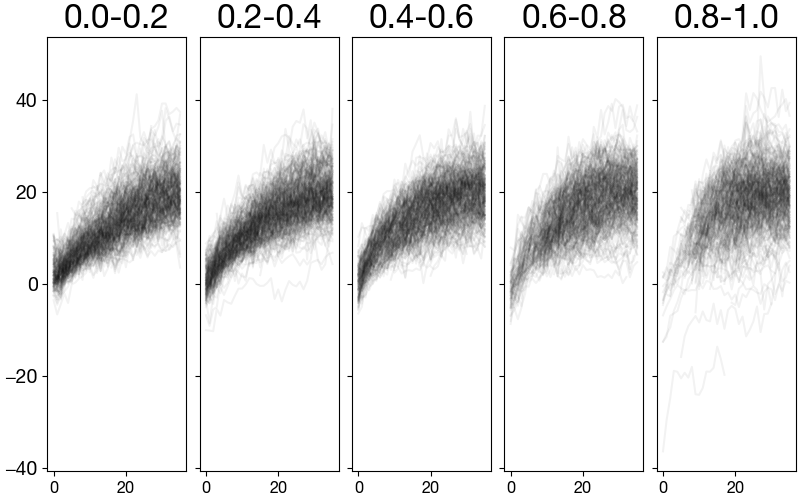

In [112]:
params = srs_params.loc[(sig_k_sel&sig_a_sel)]
traces = srs_recon.loc[params.index]
fig, ax = plt.subplots(1,5, sharey=True)
q = params['k'].quantile(np.linspace(0,1,6))
for i,(r,x) in enumerate(traces.groupby(pd.cut(params['k'], q.values))):
    print(i)
    ax[i].plot(x.values.T, 'k', alpha=0.05);
    ax[i].set_title(f"{0.2*i:0.1f}-{0.2*(i+1):0.1f}");

In [113]:
nanbkgd = srs_bsub.where(ds.labels==0)

In [114]:
be.cv_labels.load();

In [115]:
bkgd_stds = mu.single_cell.standard_dev(be.cv_labels.to_dataset(name='labels'), srs_bsub)

In [116]:
bkgd_sds = bkgd_stds.to_series().dropna()

0
1
2
3
4


Text(0, 0.5, 'SRS (a.u.)')

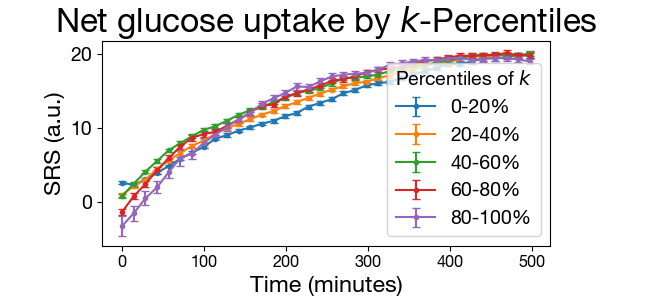

In [117]:
params = srs_params.loc[(sig_k_sel&sig_a_sel)]
traces = srs_recon.loc[params.index].drop((0,96))
fig, ax = plt.subplots(figsize=(6.52,3))
ax.set_aspect(9, anchor='C');
pct = np.linspace(0,1,6)
q = (params['k']).quantile(pct)
inds = []
for i,(r,x) in enumerate(traces.groupby(pd.cut(params['k'], q.values))):
    print(i)
    inds.append(x.index)
    ax.errorbar(t_data, x.mean().values, yerr=x.sem(), fmt='-o', capsize=3, markersize=3, label=f"{100*pct[i]:0.0f}-{100*pct[i+1]:0.0f}%");
    # ax[i].set_title(r);
ax.legend(title="Percentiles of $k$")
plt.title("Net glucose uptake by $k$-Percentiles")
plt.xlabel("Time (minutes)")
plt.ylabel("SRS (a.u.)")
# plt.savefig(fig_path+"kquantiles.png")
# m = bkgd_avgs.groupby('T').mean().values#nanbkgd.mean(list("SYX")).data
# s = bkgd_avgs.groupby('T').std().values#nand.std(list("SYX")).data
# plt.fill_between(t_data, m+s, m-s, color='k', alpha=0.5)

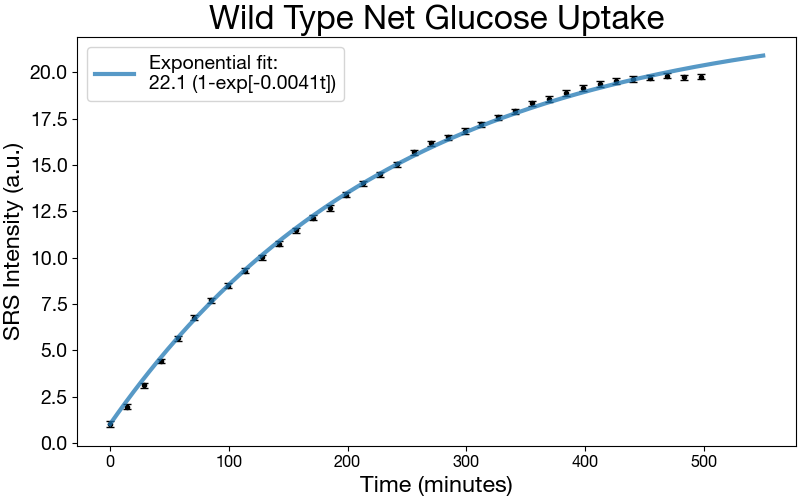

In [118]:
params = srs_params.loc[(sig_k_sel&sig_a_sel)]
df = srs_recon.loc[params.index]
# xdata = dt_min*df.columns.values + 30
y = df.mean().values
y_offset = y[0]
y = y-y_offset
sigma = df.sem().values

fit = curve_fit(exp_approach, t_data, y, sigma=sigma, p0=[20, 0.05], bounds=(0,np.inf))

a,k = fit[0]
eqn = f"Exponential fit: \n{a:0.1f} (1-exp[-{k:0.2g}t])"
xplt = np.linspace(0, 550, 250)
plt.figure()
plt.plot(xplt, exp_approach(xplt, *fit[0])+y_offset, zorder=0, linewidth=3, alpha=0.75, label=eqn)
# plt.plot(t_data, y+y_offset, 'k.', zorder=-1)
plt.errorbar(t_data, y+y_offset,yerr=sigma, fmt='k.', capsize=3, zorder=-1)
plt.title(f"Wild Type Net Glucose Uptake")
plt.legend()
plt.ylabel("SRS Intensity (a.u.)")
plt.xlabel("Time (minutes)")
if savefigs:
    plt.savefig(fig_path+"bulk_fit.png")

In [119]:
# m = check_labels_from_multiindex(ds.labels,inds[0])

# v = napari.Viewer()
# sl = v.add_image(srs_bsub)
# ml = v.add_labels(m)

In [120]:
print("mean", srs_params['k'].mean())
print("median", srs_params['k'].median())
print("selection mean", srs_params.loc[sig_k_sel&sig_a_sel,'k'].mean())
print("inv var mean", (srs_params.loc[sig_k_sel&sig_a_sel,'k']*w).sum())

mean 0.021962607
median 0.006667325738817453
selection mean 0.010253697
inv var mean 0.004747239


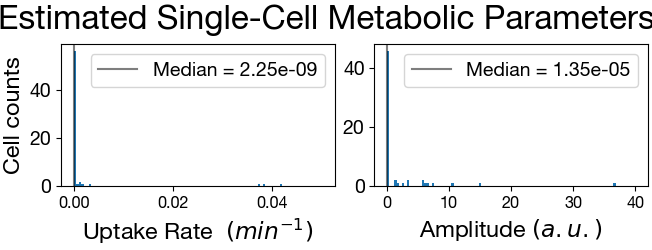

In [121]:
fig, ax = plt.subplots(1,2, figsize=(6.52, 2.5))
df = srs_params.loc[~(sig_k_sel&sig_a_sel)]
hranges = ([0,0.05], [0,40])
for i,x in enumerate('ka'):
    # w = 1./df[f'sig_{x}']
    # w /= w.sum()
    
    ax[i].hist(df[x].values, bins=100, range=hranges[i])
    ax[i].axvline(df[x].median(), color='k', alpha=0.5, label=f'Median = {df[x].median():0.3g}')
    ax[i].legend()
ax[0].set_xlabel(r"Uptake Rate  $\left(min^{-1}\right)$")
ax[1].set_xlabel(r"Amplitude $\left( a.u. \right)$")

ax[0].set_ylabel("Cell counts")

fig.suptitle("Estimated Single-Cell Metabolic Parameters")
if savefigs:
    plt.savefig(fig_path+"bad_sc_params.png")

0.10438740998506546


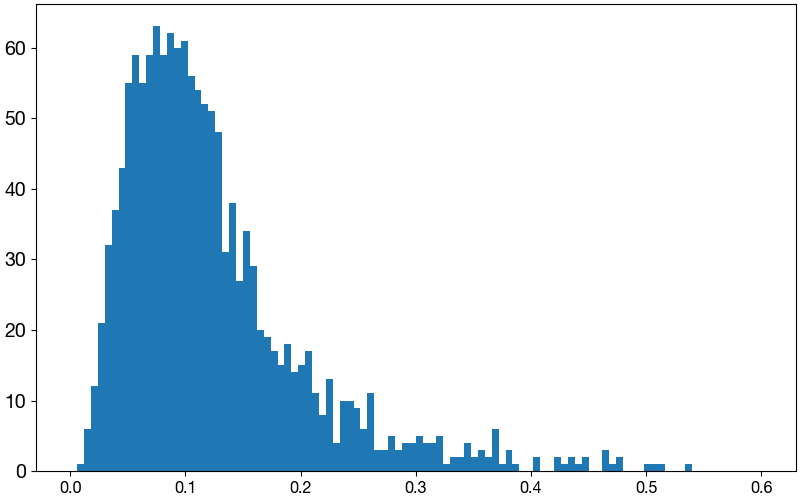

In [122]:
df = srs_params.loc[(sig_k_sel&sig_a_sel)]
p = df['a']*df['k']
plt.figure()
# x = p.loc[p>0.0002]
plt.hist(p.values, bins=100, range=(0,0.6));
print(p.median())

In [123]:
big_k = srs_params.loc[srs_params['k']>0.02].index
big_k_traces = srs_recon.loc[big_k]
n_big_k = big_k_traces.shape[0] - big_k_traces.isna().sum()
small_k = srs_params.loc[srs_params['k']<0.0025].index
small_k_traces = srs_recon.loc[small_k]
n_small_k = small_k_traces.shape[0] - small_k_traces.isna().sum()

<ErrorbarContainer object of 3 artists>

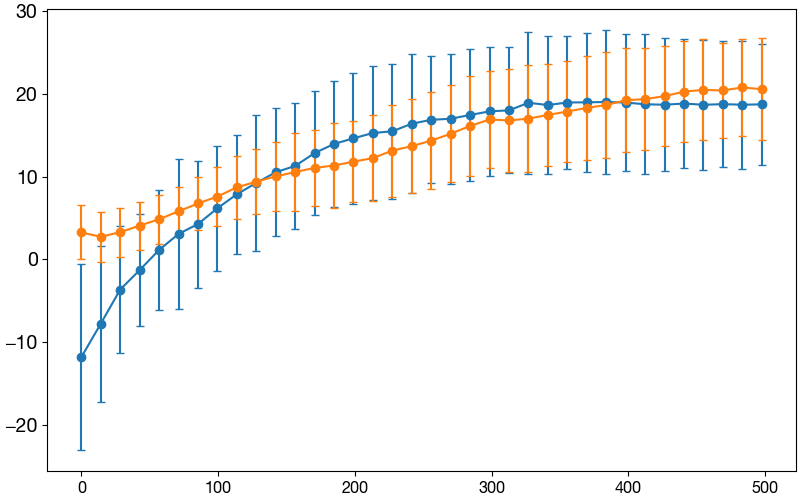

In [124]:
plt.figure()
plt.errorbar(t_data, big_k_traces.mean(), yerr = big_k_traces.std(), capsize=3, fmt='-o')
plt.errorbar(t_data, small_k_traces.mean(), yerr = small_k_traces.std(), capsize=3, fmt='-o')

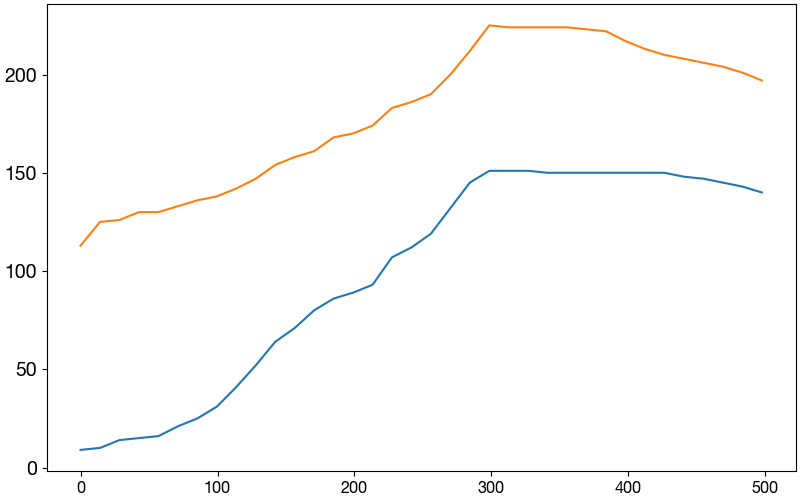

In [125]:
plt.figure()
plt.plot(t_data, n_big_k)
plt.plot(t_data, n_small_k)

Text(0.5, 1.0, 'Medium k')

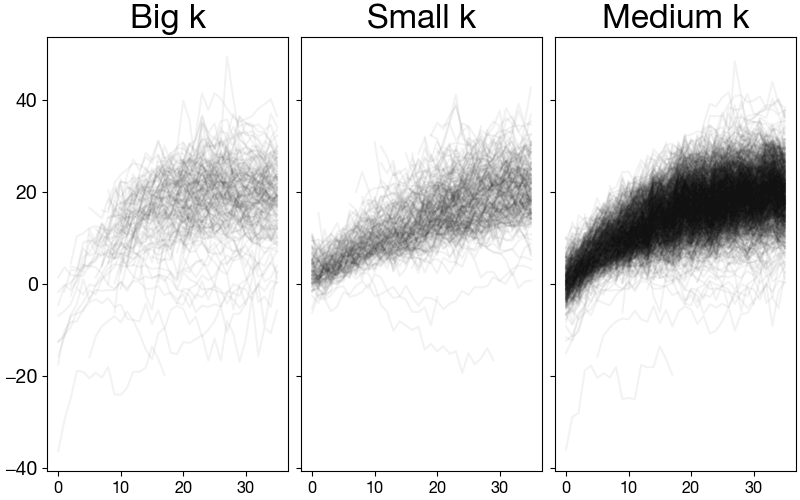

In [126]:
fig, ax = plt.subplots(1,3,sharex=True, sharey=True)
ax[0].plot(big_k_traces.values.T, 'k', alpha=0.05)
ax[0].set_title("Big k")
ax[1].plot(small_k_traces.values.T,'k', alpha=0.05) 
ax[1].set_title("Small k")
ax[2].plot(srs_clean.loc[srs_params['k'].loc[srs_params['k'].between(0.0025, 0.2)].index].values.T, 'k', alpha=0.05)
ax[2].set_title("Medium k")

In [127]:
from srs_tools.util import check_labels_from_multiindex

In [128]:
# big_k_labels = check_labels_from_multiindex(ds.labels, big_k)
# small_k_labels = check_labels_from_multiindex(ds.labels, small_k)

# v = napari.Viewer()
# il = v.add_image(aligned_fluo)
# big_l = v.add_labels(big_k_labels>0, color={1:'red'}, name="big k", opacity=0.5)
# small_l = v.add_labels(small_k_labels>0, color={1:'blue'}, name='small k', opacity=0.5)

## Age dependence

In [129]:
tser = first.reset_index('T')['T']

In [130]:
all_t0 = all_first.reset_index('T')['T']

(array([0.        , 0.        , 0.        , 0.00453515, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01360544,
        0.        , 0.00907029, 0.00907029, 0.01360544, 0.00453515,
        0.00907029, 0.01360544, 0.01360544, 0.02267574, 0.01814059,
        0.02721088, 0.02267574, 0.02267574, 0.03628118, 0.03628118,
        0.04081633, 0.02267574, 0.04081633, 0.04081633, 0.04081633,
        0.03628118, 0.04535147, 0.07256236, 0.03628118, 0.05442177,
        0.06802721, 0.05895692, 0.06349206, 0.04988662, 0.04988662,
        0.06349206, 0.05895692, 0.02721088, 0.04535147, 0.05895692,
        0.03628118, 0.04081633, 0.04988662, 0.01814059, 0.08163265,
        0.01814059, 0.04988662, 0.02267574, 0.04988662, 0.02721088,
        0.04535147, 0.03174603, 0.03174603, 0.01814059, 0.03174603,
        0.03628118, 0.02267574, 0.03174603, 0.01814059, 0.00453515,
        0.00907029, 0.00453515, 0.00907029, 0.02

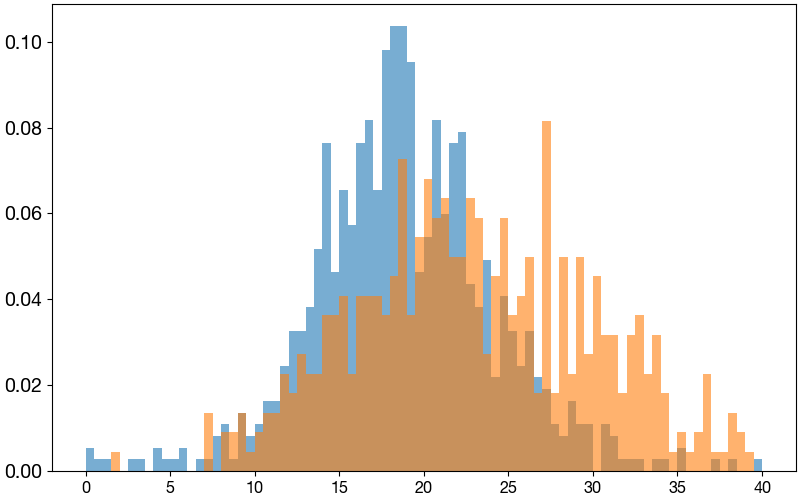

In [131]:
plt.figure()
counts, bins, patches = plt.hist(all_recon.loc[all_t0<5,35], bins=80, range=(0,40),density=True, alpha=0.6)
plt.hist(all_recon.loc[all_t0.between(20,25),35], bins=bins, density=True, alpha=0.6)

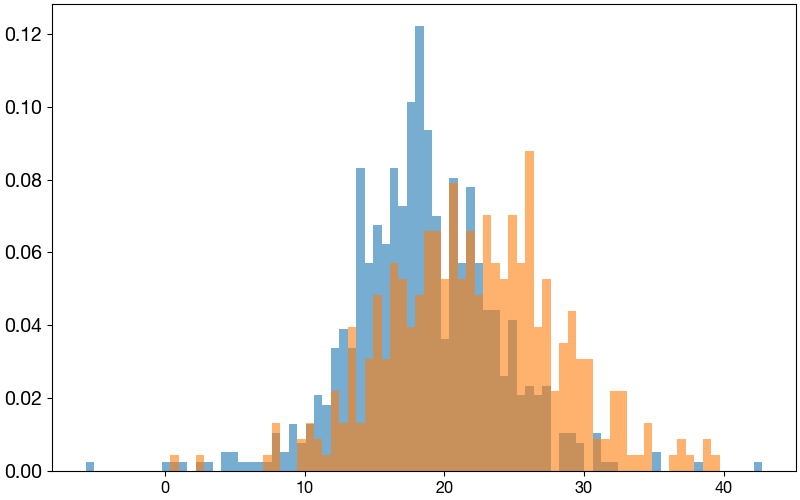

In [132]:
plt.figure()
xold= srs_recon.loc[tser<5, 35].values
xnew = srs_recon.loc[tser.between(15,21), 35].values
counts, bins, patches = plt.hist(xold, bins=80, alpha=0.6, density=True, label="Oldest")
plt.hist(xnew, bins=bins, alpha=0.6, density=True, label="Newest");

In [133]:
print(np.quantile(xnew[~np.isnan(xnew)], [0.25, 0.75]))
print(np.quantile(xold[~np.isnan(xold)], [0.25, 0.75]))

[17.97476464 26.26069946]
[15.20030585 21.74835225]


In [134]:
nold = xold.shape[0]-np.isnan(xold).sum()

In [135]:
nnew = xnew.shape[0]-np.isnan(xnew).sum()

In [136]:
for z in [xold , xnew]:
    denom = np.sqrt(z.shape[0]-np.isnan(z).sum())
    print(np.nanmean(z), np.nanmedian(z), np.nanstd(z)/denom)

18.461571551636133 18.302688048598867 0.20872038561014628
22.102430359466165 22.03109835386521 0.3149639013709396


In [137]:
Tmax = 36
ngroups = 3
width = (Tmax - nconsec)/ngroups
bins = width*np.arange(ngroups+1)-0.5
cut = pd.cut(tser, bins)
gb = srs_recon.groupby(cut.cat.codes)
by_age=gb.mean()
by_age_sem=gb.sem()
by_age_count = gb.count()

In [138]:
# plt.figure()
# plt.plot(srs_recon.loc[all_srs_params['sig_k']==0].values.T, 'k', alpha=0.1);

# plt.figure()
# plt.plot(srs_recon.loc[all_srs_params['sig_k']==0].values.T, 'k', alpha=0.1);

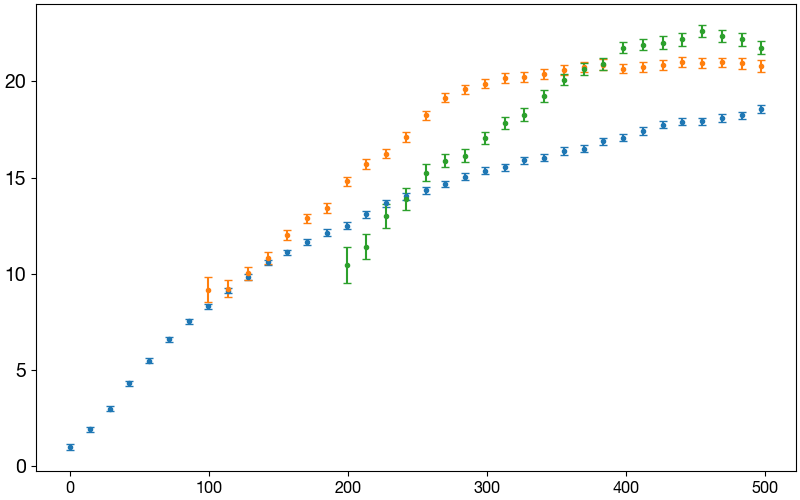

In [139]:
plt.figure()
for t in range(ngroups):
    plt.errorbar(t_data, by_age.loc[t].values, yerr=gb.sem().loc[t].values,fmt='.', capsize=3)

(-5.0, 25.0)

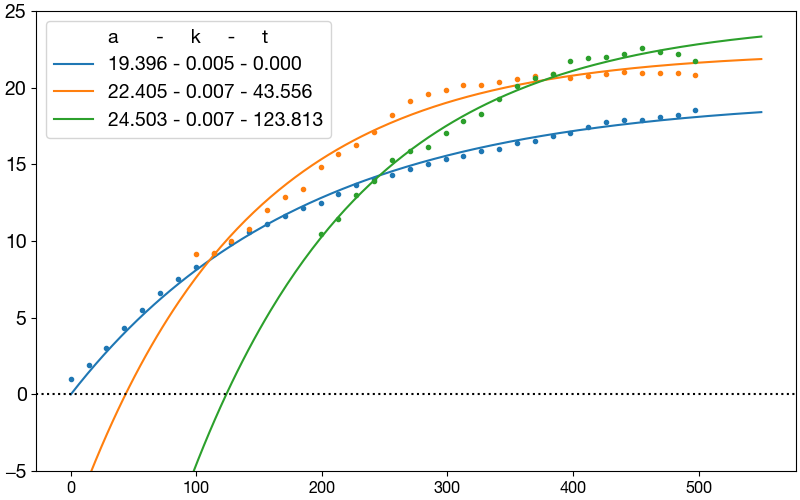

In [140]:
plt.figure()
params = pd.DataFrame(index=range(ngroups),columns=['a','k','t'])
for t in range(ngroups):
    y = by_age.loc[t].values
    mask = ~np.isnan(y)
    x = t_data[mask]
    y = y[mask]
    sigma = by_age_sem.loc[t].values[mask]
    fit = curve_fit(exp_approach2, x, y, p0=[20, 0.01,50], bounds=(0,np.inf))
    params.loc[t] = fit[0]
    plt.plot(x,y, '.', color=colors[t])
    plt.plot(xplt ,exp_approach2(xplt, *fit[0]), color=colors[t], label=" - ".join([f"{f:0.3f}" for f in fit[0]]))
plt.legend(title="a       -     k     -     t")
plt.axhline(0,color='k', linestyle=':')
plt.ylim(-5,25)

In [141]:
xplt = np.linspace(t_data.min(), t_data.max(), 101)

In [142]:
dt.mean().total_seconds()/60

14.213662416666667

In [143]:
t_bins = dt.mean().total_seconds()/60*(bins+0.5)

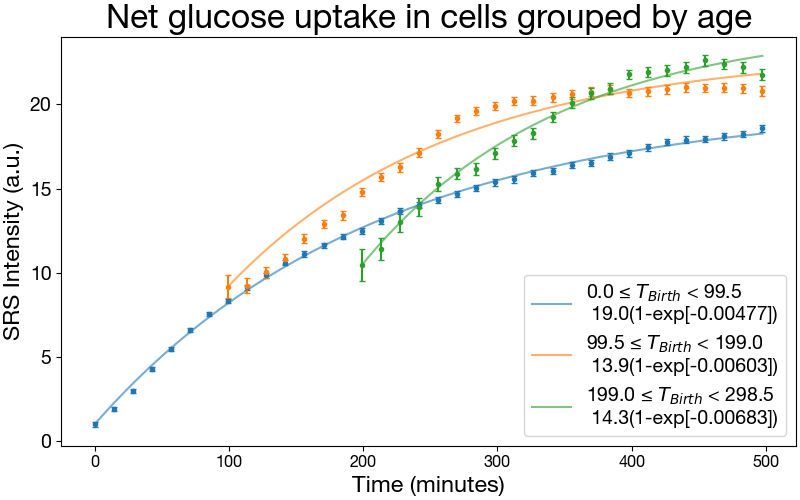

In [144]:
plt.figure()
params = pd.DataFrame(index=range(ngroups),columns=['a','k'])
fits = []
for t in range(ngroups):
    y = by_age.loc[t].values
    mask = ~np.isnan(y)
    x = t_data[mask]
    x_offset = x[0]
    x = x - x_offset
    y = y[mask]
    y_offset = y[0]
    y = y-y_offset
    fit = curve_fit(exp_approach, x, y, sigma=by_age_sem.loc[t][mask], p0=[20, 0.01], bounds=(0,np.inf))
    fits.append(fit)
    plt.errorbar(x+x_offset,y+y_offset, yerr=by_age_sem.loc[t][mask], fmt='.', capsize=2, color=colors[t])
    xx = xplt[xplt>=x_offset]
    plt.plot(xx , exp_approach(xx-x_offset, *fit[0])+y_offset, color=colors[t], label=f"{t_bins[t]:0.1f} ≤"+" $T_{Birth}$ "+f"< {t_bins[t+1]:0.1f} \n {fit[0][0]:0.1f}(1-exp[-{fit[0][1]:0.3g}])", alpha=0.6)
# plt.legend(title="    A --- k --- $y_0$")
plt.xlabel("Time (minutes)")
plt.ylabel("SRS Intensity (a.u.)")
plt.title("Net glucose uptake in cells grouped by age")
plt.legend()
if savefigs: plt.savefig(fig_path+"uptake_by_age.png")
# plt.axhline(0,color='k', linestyle=':')
# plt.ylim(0,25)

In [145]:
for f in fits:
    print(np.product(f[0]))

0.0907044251266551
0.08375062645130586
0.09753369261333558


<ErrorbarContainer object of 3 artists>

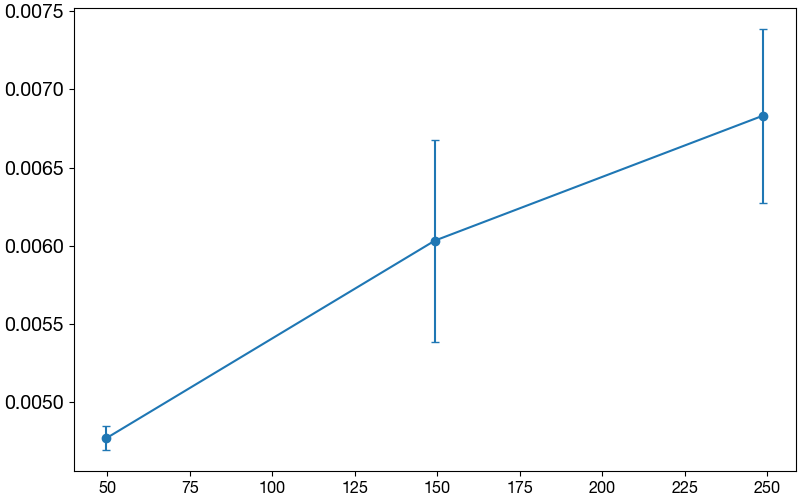

In [146]:
k = [f[0][1] for f in fits]
s = [np.sqrt(f[1][1,1]) for f in fits]
plt.figure()
plt.errorbar(t_bins[:-1] +np.mean(t_bins[:2]), k, yerr=s, fmt='-o', capsize=3)

In [147]:
codes = cut.cat.codes[cut.cat.codes>-1].rename("codes")

In [148]:
ps = pd.concat([srs_params.loc[sig_k_sel&sig_a_sel,'k'], codes], axis=1, join='inner')

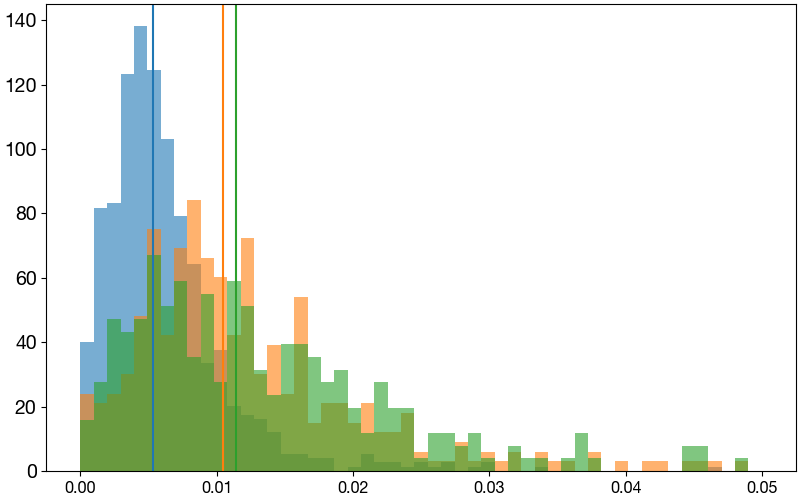

In [149]:
plt.figure()
for i in range(3):
    x = ps.loc[ps['codes']==i, 'k']
    plt.hist(x.values, bins=51, range=(0,0.05), density=True, alpha=0.6)
    plt.axvline(x.median(), color=colors[i])

$$ y = a(1-e^{-k(t-t_0)})$$

In [150]:
cell_count = (~srs_clean.isna()).sum()

In [151]:
all_count = srs_avgs.groupby('T').count()

In [152]:
lr = linregress(t_data, np.log2(all_count.values))

In [153]:
lr2 = linregress(t_data[:20], np.log2(all_count.values)[:20])

In [154]:
print(1/lr2.slope)

223.9748445233523


In [155]:
print(1/lr.slope)

249.81958269962283


[]

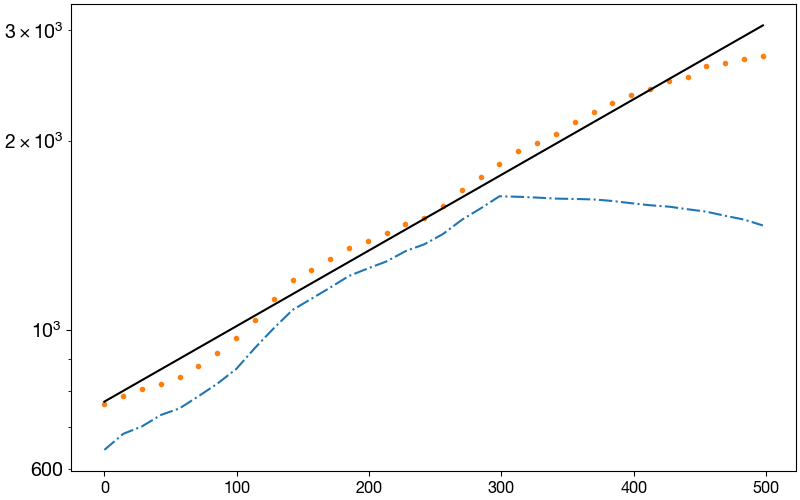

In [156]:
plt.figure()
plt.plot(t_data, cell_count.values, '-.')
plt.plot(t_data, all_count.values.astype(int), '.')
plt.plot(t_data, np.exp(np.log(2)*(lr.slope*t_data + lr.intercept)), 'k')
plt.semilogy()

(-5.0, 25.0)

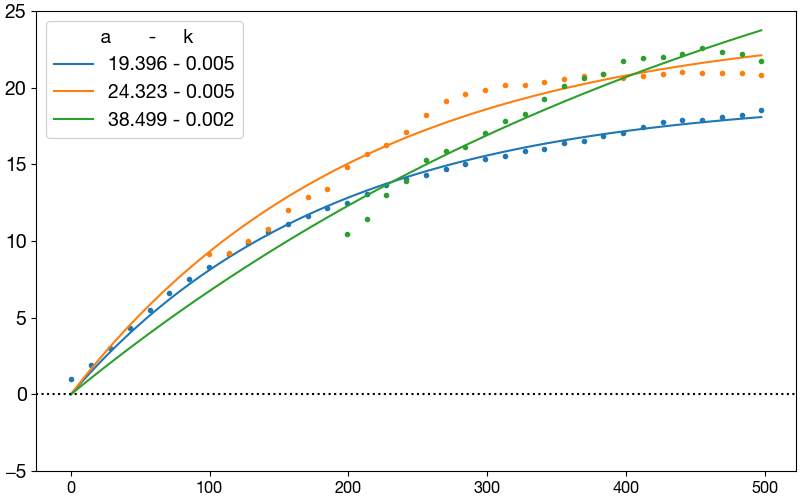

In [157]:
plt.figure()
params = pd.DataFrame(index=range(5),columns=['a','k'])
for t in range(3):
    y = by_age.loc[t].values
    mask = ~np.isnan(y)
    x = t_data[mask]
    y = y[mask]
    sigma = by_age_sem.loc[t].values[mask]
    fit = curve_fit(exp_approach, x, y, p0=[20, 0.01], bounds=(0,np.inf))
    params.loc[t] = fit[0]
    plt.plot(x,y, '.', color=colors[t])
    plt.plot(xplt ,exp_approach(xplt, *fit[0]), color=colors[t], label=" - ".join([f"{f:0.3f}" for f in fit[0]]))
plt.legend(title="    a       -     k   ")
plt.axhline(0,color='k', linestyle=':')
plt.ylim(-5,25)

In [158]:
q = times.groupby('T').quantile([0.025, 0.975])

In [159]:
errs = q.unstack(level=-1).values.T

## Area growth rates

In [160]:
# slower to use dask delayed by ~50%
# df = growth_cells

# all_area_params = pd.DataFrame(index=df.index, columns=['a','k', 't', 'sig_a', 'sig_k', 'sig_t'], dtype='f4')

# for i, (idx, s) in enumerate(tqdm(df.iterrows(), total=len(df))):
#     y = s.values
#     mask = ~np.isnan(y)
#     y = y[mask]
#     x = t_data[mask]
#     out = fit_exp(x,y,[200,0.05,x[0]])
#     all_area_params.loc[idx] = out

# # unconverged = all_params.loc[all_params.isna().any(1)].index
# area_params = all_area_params.dropna()

# combo_rates = pd.concat([area_params['k'].rename('k_srs'), srs_params['k'].rename('k_area')],axis=1, join='inner')

# combo_rates.corr(method='spearman') 

In [161]:
# srs_total_mean = srs_bsub.where(ds.labels>0).mean(list('YX'))
# srs_scaled_avg = (1+kopt.values)*srs_total_mean

In [162]:
srs_scaled_avg = srs_recon.groupby('S').mean()

In [163]:
a0 = areas.unstack('T')

In [164]:
cell_counts = (a0>0).groupby('S').sum()

Text(0, 0.5, 'SRS intenstity (a.u.)')

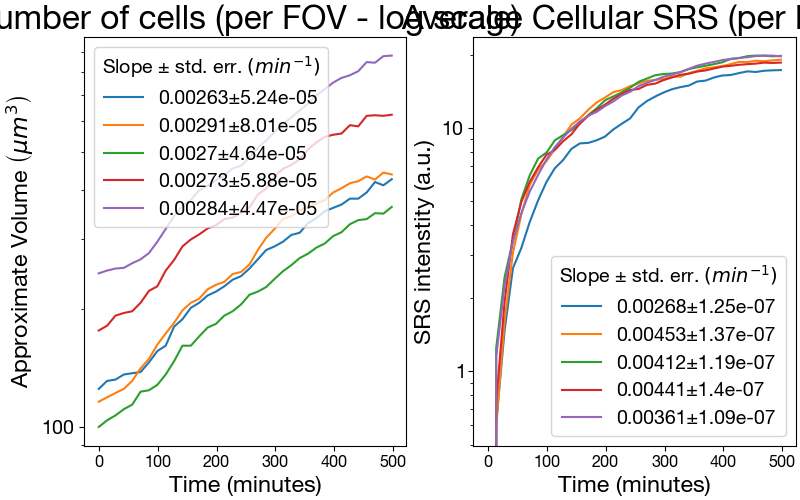

In [165]:
fig, ax = plt.subplots(1,2)
area_slope = []
srs_slope = []
log = np.log
for i in range(5):
    # a = vol_unit*vfactor*(total_area.data[i]**(3./2))
    a = cell_counts.values[i]
    # a = total_area.data[i]
    # a = volumes.values[i]
    lr_a = linregress(t_data, log(a))
    area_slope.append(lr_a.slope)
    ax[0].plot(t_data, a, color=colors[i], label=f"{lr_a.slope:0.3g}±{lr_a.stderr:0.3g}")
    # s = srs_total_mean.data[i]
    # s = srs_scaled_avg.data[i]
    s = srs_scaled_avg.values[i]
    s = s-s.min()
    
    # s = srs_recon.loc[i].mean().values
    # lr_s = linregress(t_data, np.log(s))
    fit_s = fit_exp(t_data, s, [20,0.01])
    # srs_slope.append(lr_s.slope)
    srs_slope.append(fit_s[1])
    # ax[1].plot(t_data, s, color=colors[i], label=f"{lr_s.slope:0.3g}±{lr_s.stderr:0.3g}")
    ax[1].plot(t_data, s, color=colors[i], label=f"{fit_s[1]:0.3g}±{fit_s[-1]:0.3g}")
for a in ax:
    a.legend(title="Slope ± std. err. $\\left(min^{-1}\\right)$")
    a.semilogy()
    a.set_xlabel("Time (minutes)")
ax[0].set_title("Number of cells (per FOV - log scale)")
ax[0].set_ylabel("Approximate Volume $\\left(\mu m^3 \\right)$")
ax[1].set_title("Average Cellular SRS (per FOV)")
ax[1].set_ylabel("SRS intenstity (a.u.)")

In [166]:
r=[]
for x,y in zip(srs_slope,area_slope):
    r.append(x/y)
    print(x, y, x/y)

0.0026781644130079475 0.002625499182310069 1.020059130489441
0.004529261049897552 0.002908795077084656 1.5570918300772876
0.004122288488741067 0.0027046612848720688 1.524142232448176
0.0044129152542479785 0.002734184625291178 1.613978519749018
0.003609963855359837 0.002840882236655038 1.2707192888116141


In [167]:
print(r)

[1.020059130489441, 1.5570918300772876, 1.524142232448176, 1.613978519749018, 1.2707192888116141]


In [168]:
np.mean(r)

1.3971982003151073

In [169]:
np.std(r)/np.sqrt(5)

0.09937912458271551

In [170]:
print(f"{np.mean(r):0.3g} ± {np.std(r)/np.sqrt(5):0.3g}")

1.4 ± 0.0994


In [171]:
tf = first.reset_index('T')['T']

In [172]:
final_labels = check_labels_from_multiindex(ds.labels, srs_recon.index)

In [173]:
sorted(tf.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [174]:
m1 = check_labels_from_multiindex(final_labels, tf.loc[tf==21].index)

In [175]:
v = napari.Viewer()
il = v.add_image(aligned_fluo)
lall = v.add_labels(final_labels)
ll = v.add_labels(m1)

In [176]:
b1= [
    (3, 34, 178),
    (2, 8, 101),
    (2, 58, 103),
    (2, 76, 104),
    (0,115,157),
    (4, 50, 248),
    (4, 60 , 249),
    (4, 230 , 252),
]

In [177]:
b11 = [
    (2, 67, 167),
    (3, 126, 320),
    (3, 107, 318),
    (3, 101, 316),
    (3, 64, 314),
    (3, 15, 309),
    (4, 86, 386),
    (4, 138, 389),
    (4, 143, 390),
]

In [178]:
b21 = [
    (0, 176, 337),
    (0, 181, 334),
    (2, 52, 248),
    (2, 28, 245),
    (2, 39, 247),
    (2, 101,242),
    (2, 125, 228),
    (3, 122, 464),
    (3, 104, 460),
    (3, 317, 461),
    (4, 120, 593),
    (4, 312, 583),
]

In [179]:
pairs = {1:b1, 11:b11, 21:b21}

In [180]:
md_dict = {}
for t,l in pairs.items():
    vals = np.zeros((len(l), 2))
    for i,(s,m,d) in enumerate(l):
        m = m-1
        d = d-1
        vals[i,0] = srs_recon.loc[(s,m), t]
        vals[i,1] = srs_recon.loc[(s,d), t]
    md_dict[t] = vals

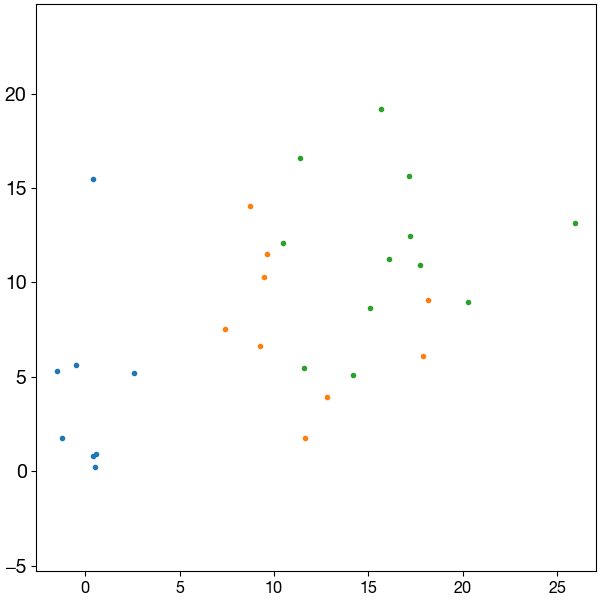

In [181]:
plt.figure(figsize=(6,6))
plt.gca().axis('equal')
for t,v in md_dict.items():
    plt.plot(v[:,0], v[:,1], '.')

In [182]:
for k,v in md_dict.items():
    print(k, (v[:,1]-v[:,0]))

1 [ 6.82108499  0.34340966  0.36962229  6.11895019 -0.2835629   2.60743046
 15.08226573  2.99555345]
11 [ -8.88369845   0.83429505  -2.61671049  -9.88064682   5.31091059
 -11.79963735   0.14869881  -9.07561453   1.88745462]
21 [  5.21023011  -4.84785417   1.59561212  -6.08464108  -9.09663528
 -11.29052972  -1.52746294  -4.75368715  -6.46922439 -12.82527035
   3.52410657  -6.79931775]


In [183]:
mtraces = pd.DataFrame()
dtraces = pd.DataFrame()
for t,l in pairs.items():
    for i,(s,m,d) in enumerate(l):
        m = m-1
        d = d-1
        mtraces = pd.concat([mtraces, srs_recon.loc[(s,m)].to_frame().T])
        dtraces = pd.concat([dtraces, srs_recon.loc[(s,d)].to_frame().T])

In [184]:
x = srs_recon.loc[(s,m)].to_frame().T

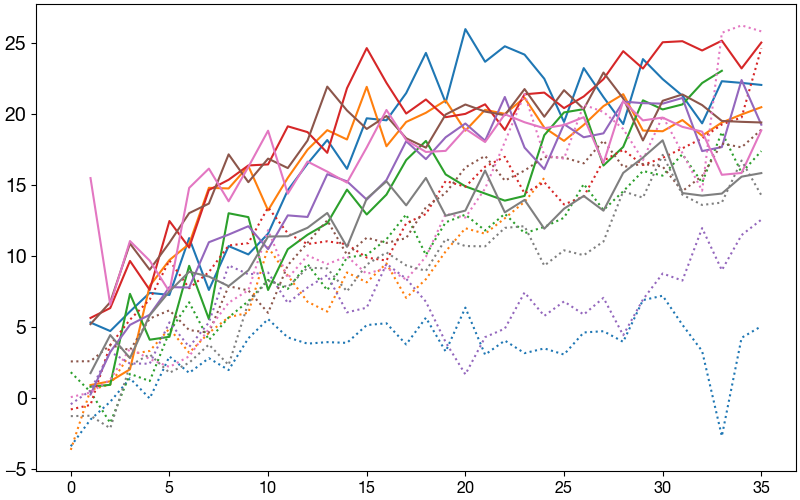

In [185]:
plt.figure()
for i in range(len(b1)):
    plt.plot(mtraces.iloc[i],':', color=colors[i])
    plt.plot(dtraces.iloc[i], color=colors[i])

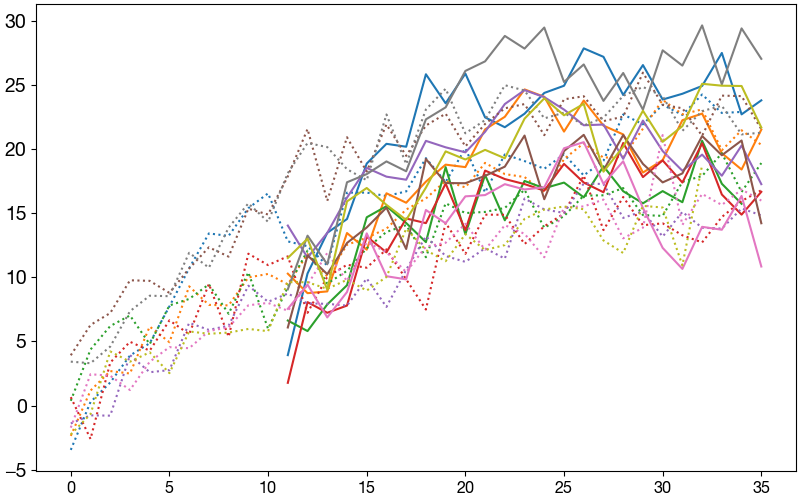

In [186]:
plt.figure()
for i in range(len(b11)):
    plt.plot(mtraces.iloc[len(b1)+i],':', color=colors[i])
    plt.plot(dtraces.iloc[len(b1)+i], color=colors[i])

In [187]:
print(md_dict[11])

[[12.81887899  3.93518055]
 [ 9.46242952 10.29672457]
 [ 9.25357978  6.63686929]
 [11.65222975  1.77158293]
 [ 8.74389329 14.05480388]
 [17.89427751  6.09464015]
 [ 7.40055471  7.54925352]
 [18.15125538  9.07564085]
 [ 9.63390469 11.52135931]]


In [188]:
from mpl_interactions import hyperslicer

In [32]:
vmin, vmax = srs_bsub.quantile([0.02, 0.995]).data

In [33]:
norm_aligned_fluo = mu.normalize_fluo(aligned_fluo, mode_cutoff_ratio=np.inf)

In [34]:
srs_max = ds.images.isel(C=-1).max('Z').load()

In [35]:
sel = {'S':4,'Y':slice(215,505), 'X':slice(215,505)}

In [36]:
demo_labels = ds.labels.isel(sel)

In [37]:
inds = np.unique(demo_labels)[1:]
colors = np.random.rand(inds.shape[0], 3)

In [38]:
show_labels = np.zeros((*demo_labels.shape,3))

In [39]:
for l,c in zip(inds, colors):
    show_labels[demo_labels==l]=c

In [40]:
show_labels = xr.DataArray(show_labels, dims=list("TYXc"))
show_labels=show_labels.where(show_labels>0)

Text(0.5, 1.0, 'Fluorescence')

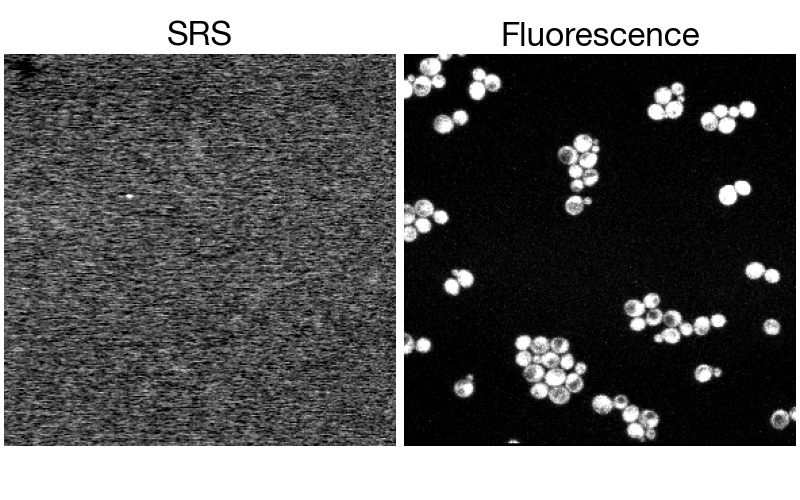

In [41]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
c = hyperslicer(srs_bsub.isel(sel), vmin=vmin, vmax=vmax, ax=ax[0], cmap='gray')
_ = hyperslicer(norm_aligned_fluo.isel(sel), controls=c , ax=ax[1],cmap='gray')
# _ = hyperslicer(ds.labels.isel(sel), cmap=labels_cmap, vmin=1, controls=c, alpha=0.6, ax=ax[0])
# _ = hyperslicer(show_labels, is_color_image=True, controls=c, alpha=0.5, ax=ax[0])
# _ = hyperslicer(show_labels, is_color_image=True, controls=c, alpha=0.5, ax=ax[1])

for a in ax:
    a.axis("off")
ax[0].set_title("SRS")
ax[1].set_title("Fluorescence")

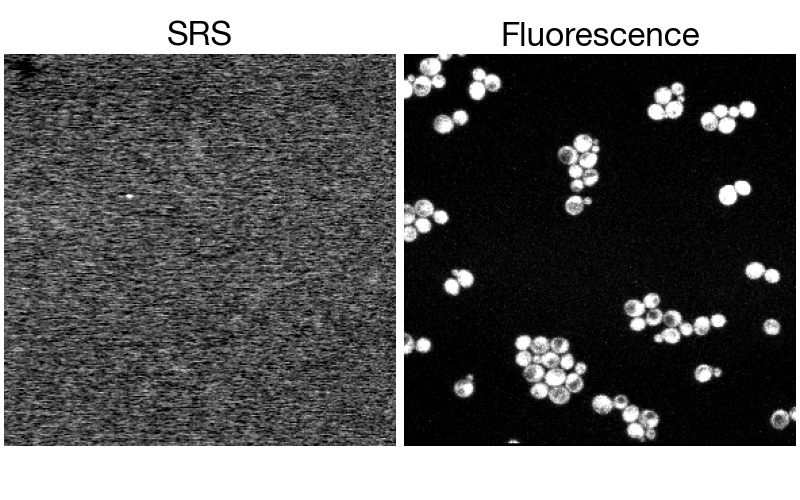

In [45]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].imshow(srs_bsub.isel(sel).isel(T=0), vmin=vmin, vmax=vmax,  cmap='gray')
ax[1].imshow(norm_aligned_fluo.isel(sel).isel(T=0),cmap='gray')
# _ = hyperslicer(ds.labels.isel(sel), cmap=labels_cmap, vmin=1, controls=c, alpha=0.6, ax=ax[0])
# _ = hyperslicer(show_labels, is_color_image=True, controls=c, alpha=0.5, ax=ax[0])
# _ = hyperslicer(show_labels, is_color_image=True, controls=c, alpha=0.5, ax=ax[1])

for a in ax:
    a.axis("off")
ax[0].set_title("SRS")
ax[1].set_title("Fluorescence")
plt.savefig(fig_path+"movie_still.png")

In [205]:
ax[0].get_xlim()

(217.5901482385502, 490.802528174516)

In [206]:
ax[0].get_ylim()

(214.97567570327774, 505.18212711851413)

In [231]:
c.save_animation("/Users/johnrussell/Documents/figures/2023-07-figs-slides/srs_fluo.gif",param='T',fig=fig, interval=60)

In [234]:
srs_recon.loc[(srs_recon.iloc[:,:10]>0).all(axis=1)].head()

T               0         1         2         3          4          5   \
S CellID                                                                 
0 7       3.202729  4.174428  5.263010  8.067112  10.045665   6.607394   
  11      6.344808  7.544728  9.045493  7.516619  10.708889  12.387111   
  15      4.308075  4.965403  4.291377  5.067594   7.017404   3.027353   
  21      7.562238  1.784124  2.931967  2.578937   6.037487   7.449545   
  25      5.709395  5.052185  3.131137  6.119387   6.628112   9.784878   

T                6          7          8          9   ...         26  \
S CellID                                              ...              
0 7       11.881395  11.439309   8.919038  11.223110  ...  22.362685   
  11      11.589909  13.861485  15.027173  14.190747  ...  23.108052   
  15       7.263981   6.730319  10.495260   9.910067  ...  16.413933   
  21       7.135892   5.672335   8.473393   8.116795  ...  14.597973   
  25      10.725032  12.877962  11.392400  11.568620  ...  19.386880   

T                27         28         29         30         31         32  \
S CellID                                                                     
0 7       23.526592  21.558218  26.173867  24.543186  20.062547  22.392177   
  11      26.336136  19.642676  25.992803  21.600496  24.593777  22.442319   
  15      18.589949  15.768577  13.877197  18.014976  16.749900  16.854683   
  21      18.582742  17.683383  18.093971  17.148841  16.880308  15.702603   
  25      19.617953  18.839777  19.667809  20.891126  21.053670  20.209162   

T                33         34         35  
S CellID                                   
0 7       20.317580  21.812087  21.623587  
  11      23.058112  24.079710  26.161535  
  15      17.002775  19.539625  15.176288  
  21      16.647544  16.891455  17.285396  
  25      22.494609  17.893776  19.227577  

[5 rows x 36 columns]